In [502]:
import scipy
import scipy.io
import numpy as np
import json
import glob
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from bisect import bisect_left
import statsmodels.api as sm
import os
from scipy.signal import convolve
from analysis_pkg.tools.util import normalize
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pickle
from pyglmnet import GLM, simulate_glm

def load_bpod_data(dpath):
    with open(dpath, 'r') as file:
        data = json.load(file)
    return data

def take_closest(ms_stamps, bpod_stamps):
    """
    Assumes ms_stamps is sorted. Returns closest stamps to the given bpod_stamps.

    If two numbers are equally close, return the smallest number.
    """
    msAlignedIndex = []
    for bpod_stamp in bpod_stamps:
        pos = bisect_left(ms_stamps, bpod_stamp)
        if pos == 0:
            return ms_stamps[0]
        if pos == len(ms_stamps):
            return ms_stamps[-1]
        before = ms_stamps[pos - 1]
        after = ms_stamps[pos]
        if after - bpod_stamp < bpod_stamp - before:
            msAlignedIndex.append(np.where(ms_stamps ==after))
        else:
            msAlignedIndex.append(np.where(ms_stamps ==before))
    return np.squeeze(np.array(msAlignedIndex))
    
def get_state_time(state, bpod_data, trialnumbers=None):
    """
    Input a state name and bpod_data. Return the time stamp of the state(relative to trial start)
    """
    onsets = []
    offsets = []
    if trialnumbers:
        for trialnumber in trialnumbers:
            trial = bpod_data["SessionData"]['RawEvents']['Trial'][trialnumber]
            onsets.append(np.array(trial['States'][state]).flatten()[0])
            offsets.append(np.array(trial['States'][state]).flatten()[1])
    else:
        for trial in bpod_data["SessionData"]['RawEvents']['Trial']:
            onsets.append(np.array(trial['States'][state]).flatten()[0])
            offsets.append(np.array(trial['States'][state]).flatten()[1])
    return np.array(onsets, dtype=float), np.array(offsets, dtype=float)
    
    
def get_RPE_neuron_activities(trialRewards, calcium_activities, calcium_baselines=None):
    """Select RPE relative neurons using the method from Muller. 2024 """
    if not calcium_baselines:
        calcium_baselines = np.zeros(calcium_activities.shape)
    RPE_neurons = []
    RPE_neurons_id = []
    for i, singleNeuronActivity in enumerate(calcium_activities):
        trialRewards_constant = sm.add_constant(trialRewards)
        model = sm.OLS(singleNeuronActivity, trialRewards_constant).fit()
        if model.pvalues[1] < 0.05:
            # print(singleNeuronActivity)
            # print(calcium_baselines[i])
            # print(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons.append(singleNeuronActivity-calcium_baselines[i])
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons), np.array(RPE_neurons_id)

def z_score(data, axis=1):
    return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)

def subtract_mean(data, axis=1):
    return (data-data.mean(axis=axis, keepdims=True))

def mean_across_events(events, raw_neural_activities, fps=30, duration=2):  
    sum_acitivities = np.zeros((raw_neural_activities.shape[0],fps*duration*2))
    for event in events:
        raw_neural_activities_cue_onset = np.array(raw_neural_activities[:, event-duration*fps:event+duration*fps])
        sum_acitivities = raw_neural_activities_cue_onset + sum_acitivities
    return sum_acitivities/len(events)

def create_raised_cosine_basis(n_basis, window_length_frames, dt=1):
    """
    Create a set of raised cosine basis functions over a specified window (in frames).

    Parameters:
      n_basis             : int
          Number of basis functions.
      window_length_frames: int or float
          Duration (in frames) over which to define the basis functions.
      dt                  : int or float, optional
          Time resolution. For frame-based data, dt=1 (one frame per step).

    Returns:
      t         : 1D numpy array
          The frame vector spanning the window.
      basis_set : 2D numpy array of shape (n_basis, len(t))
          Each row corresponds to one raised cosine basis function.
    """
    # Create a vector of frame indices over the window.
    t = np.arange(0, window_length_frames, dt)
    
    # Determine centers for each basis function, evenly spaced over the window.
    centers = np.linspace(0, window_length_frames, n_basis)
    
    # Choose a width for the basis functions.
    # The width controls how broad each function is. You can adjust the scaling factor as needed.
    width = (window_length_frames / (n_basis - 1)) * 1.5  # 1.5 is an adjustable scaling factor.
    
    basis_set = []
    for center in centers:
        # Compute the argument for the cosine, then clip it so that it only has nonzero values over a finite interval.
        cosine_arg = np.clip((t - center) * np.pi / width, -np.pi, np.pi)
        basis = (np.cos(cosine_arg) + 1) / 2  # Scale to range [0,1]
        
        # Optionally zero out values outside a window centered on the current basis function.
        basis[t < (center - width/2)] = 0
        basis[t > (center + width/2)] = 0
        
        basis_set.append(basis)
    
    return t, np.array(basis_set)

def poisson_deviance(y, mu):
    """
    Compute the deviance for Poisson data.
    
    Parameters:
      y  : array of observed counts
      mu : array of predicted counts (should be > 0)
      
    Returns:
      The deviance value.
    """
    # Use np.where to avoid computing log(0); when y==0, treat y*log(y/mu) as 0.
    term = np.where(y == 0, 0, y * np.log(y / mu)) - (y - mu)
    return 2 * np.sum(term)

def find_all_zero_crossings(x, y):
    zero_crossings = []

    for i in range(1, len(y)):
        if y[i-1] < 0 and y[i] > 0:
            # Linear interpolation to find the x where y crosses 0
            x0, y0 = x[i-1], y[i-1]
            x1, y1 = x[i], y[i]
            zero_x = x0 - y0 * (x1 - x0) / (y1 - y0)
            zero_crossings.append(zero_x)

    return zero_crossings

from scipy.signal import convolve
def convolve_event_with_basis(event_vector, basis_set):
    """
    Convolve a binary event vector with a set of temporal basis functions.
    
    Parameters:
    - event_vector: np.array of shape (n_frames,)
    - basis_set: np.array of shape (n_basis, window_length)
    
    Returns:
    - design_matrix: np.array of shape (n_frames, n_basis)
    """
    n_basis, window_length = basis_set.shape
    n_frames = len(event_vector)
    
    design_matrix = np.zeros((n_frames, n_basis))
    
    for i in range(n_basis):
        # Convolve and truncate to original length
        conv_result = convolve(event_vector, basis_set[i], mode='full')[:n_frames]
        design_matrix[:, i] = conv_result
        
    return design_matrix



In [598]:
FS = 20000


def load_data(mouse, date):
    data = {}

    date_in_bpod = date.replace("-", "")

    ### load wavesurfer stamps
    try:
        ms_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_ms.mat")['ms_frames_samplingstamps'])
        bpod_trialstart_stamps = np.squeeze(scipy.io.loadmat(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/ws_data/processed/{mouse}/{mouse}_{date}_bpod.mat")['bpod_trialstart_samplingstamps'])
    except Exception as e:
        print(e)

    ### load bpod results
    try:
        bpod_data = load_bpod_data(glob.glob(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/bpod_data/{mouse}/*{mouse}*{date_in_bpod}*')[0])
        trialRewards = np.array(bpod_data["SessionData"]['TrialRewards'])
    except Exception as e:
        print(e)

    ### Exclude wrong trials
    wrongTrials = []
    for i, trial in enumerate(bpod_data['SessionData']['RawEvents']['Trial']):
        if trial['States']['WrongPort'][0]:
            wrongTrials.append(i)
    trialRewards = np.delete(trialRewards, wrongTrials)

    ### load minian results
    try:
        minian_results = xr.open_dataset(f"/Users/fgs/HMLworkplace/Arena_analysis/Data/minian_data/new_parameters/{mouse}_{date}.netcdf")
    except Exception as e:
        print(e)

    ### load caliai results
    try:
        calcium_traces_caliali = scipy.io.loadmat(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/caliali_data/{mouse}_{date_in_bpod}_C.mat')
        calcium_traces_caliali = list(calcium_traces_caliali.values())[-1]

        spikes_caliali = scipy.io.loadmat(f'/Users/fgs/HMLworkplace/Arena_analysis/Data/caliali_data/{mouse}_{date_in_bpod}_S.mat')
        spikes_caliali = list(spikes_caliali.values())[-1]
    except Exception as e:
        print(e)

    ### Handle sessions during which the wavesurfer crashed
    try:
        info = ''
        if len(bpod_trialstart_stamps) < 40:
            info = 'wavesufer crashed session'
            for i in range(len(bpod_trialstart_stamps), 40):
                next_stamp = bpod_trialstart_stamps[i-1] + bpod_data['SessionData']['RawEvents']['Trial'][i-1]['States']['EndState'][1] * FS
                bpod_trialstart_stamps = np.append(bpod_trialstart_stamps, next_stamp)
                
        bpod_trialstart_stamps = np.delete(bpod_trialstart_stamps, wrongTrials)

        if (len(minian_results.frame) - len(ms_stamps)) >= 150:
            info = 'wavesufer crashed session'
            for i in range(len(ms_stamps), len(minian_results.frame)):
                next_stamp = ms_stamps[i-1] + int(FS/30)
                ms_stamps = np.append(ms_stamps, next_stamp)
    except Exception as e:
        print(f'Information missing during handle wavesurfer crashed session{e}')

    drinkDurations = np.zeros(40)
    try:
        temporal_downsample = 2


        rewardOnsets,rewardOffsets = get_state_time('Reward', bpod_data)
        trialEnds,_ = get_state_time('EndState', bpod_data)
        toneTimes,_ = get_state_time('Tone', bpod_data)
        
        drinkOnsets, drinkOffsets = get_state_time('Drinking', bpod_data)
        drinkDurations = (drinkOffsets - drinkOnsets)[~np.isnan(drinkDurations)]


        # ws_rewardTimes = (rewardTimes)*FS + bpod_trialstart_stamps
        # ms_rewardTimes = (take_closest(ms_stamps, ws_rewardTimes)/temporal_downsample).astype(int)

        # ws_toneTimes = (toneTimes)*FS + bpod_trialstart_stamps
        # ms_toneTimes = (take_closest(ms_stamps, ws_toneTimes)/temporal_downsample).astype(int)

        # ws_trialEnds = (trialEnds)*FS + bpod_trialstart_stamps
        # ms_trialEnds = (take_closest(ms_stamps, ws_trialEnds)/temporal_downsample).astype(int)

        # ms_trialstarts = (take_closest(ms_stamps, bpod_trialstart_stamps)/temporal_downsample).astype(int)



        ws_rewardOnsets = (rewardOnsets)*FS + bpod_trialstart_stamps
        ms_rewardOnsets = (np.searchsorted(ms_stamps[::2], ws_rewardOnsets))

        ws_rewardOffsets = (rewardOffsets)*FS + bpod_trialstart_stamps
        ms_rewardOffsets = (np.searchsorted(ms_stamps[::2], ws_rewardOffsets))

        ws_toneTimes = (toneTimes)*FS + bpod_trialstart_stamps
        ms_toneTimes = (np.searchsorted(ms_stamps[::2], ws_toneTimes))

        ws_trialEnds = (trialEnds)*FS + bpod_trialstart_stamps
        ms_trialEnds = (np.searchsorted(ms_stamps[::2], ws_trialEnds))

        ms_trialstarts = (np.searchsorted(ms_stamps[::2], bpod_trialstart_stamps))


        ### Get binary reward onset matrix
        reward_onset = np.zeros((calcium_traces_caliali.shape[1],1))
        for i, ms_rewardOnset in enumerate(ms_rewardOnsets):
            reward_onset[ms_rewardOnset] = trialRewards[i]

        reward_binary = np.zeros((calcium_traces_caliali.shape[1],1))
        for i, ms_rewardOffset in enumerate(ms_rewardOffsets):
            reward_binary[ms_rewardOffset] = trialRewards[i]

        trialStart = np.zeros((calcium_traces_caliali.shape[1],1))
        for i, ms_trialstart in enumerate(ms_trialstarts):
            trialStart[ms_trialstart] = 1

        toneOnsets = np.zeros((spikes_caliali.shape[1],1))
        for i, ms_toneTime in enumerate(ms_toneTimes):
            toneOnsets[ms_toneTime] = 1
        
    except Exception as e:
        print(f'Critical information missing: {e}')

    ### Basic task variables
    try:
        data['tone_onset'] = toneOnsets.T
        data['drinkDurations'] = drinkDurations
        data['trialRewards'] = trialRewards
        data['reward_onset'] = reward_onset.T
        data['reward_offset'] = reward_binary.T
        data['trialStart'] = trialStart.T
        data['calcium_trace'] = calcium_traces_caliali
        data['spike'] = spikes_caliali.toarray()
        data['info'] = info
    except Exception as e:
        print(f'data not fully loaded{e}')

    return data


def select_RPEneurons_GLM(neural_data, design_matrix, is_pyglm=False):
    # -------------------------------
    # Set parameters for demonstration.
    # Replace these with your actual design matrix and response data.
    n_frames = neural_data.shape[1]        # total number of frames in the session
    n_predictors = 2       # e.g., intercept + 8 port condition columns + reward regressor
    n_neurons = neural_data.shape[0]         # number of neurons

    # For demonstration purposes, create dummy data.
    # For Poisson regression, the response must be nonnegative integers.
    np.random.seed(142)
    X_input = design_matrix
    X_data = X_input  # Your actual design matrix
    #Y_data = calcium_traces  # Simulated count data
    Y_data = neural_data.T  # Simulated count data
    # -------------------------------
    # 10-Fold Cross Validation for performance evaluation (Poisson GLM)
    kf = KFold(n_splits=5, shuffle=True, random_state=142)
    all_neuron_r2 = np.zeros(n_neurons)

    # Initialize an array to store the cross-validated fraction deviance explained (FDE) for each neuron.
    all_neuron_fde = np.zeros(n_neurons)

    # Loop over neurons
    for neuron_idx in range(n_neurons):
        y_neuron = Y_data[:,neuron_idx]  # Get the count data for this neuron (length = n_frames)
        fold_fde = []
        
        # Iterate through the 10 folds.
        for train_index, test_index in kf.split(X_data):
            X_train, X_test = X_data[train_index, :], X_data[test_index, :]
            y_train, y_test = y_neuron[train_index], y_neuron[test_index]
            
            # Fit the Poisson GLM (default link is log).

            if is_pyglm:
                glm = GLM(distr='poisson', alpha=1.0, reg_lambda=0.01)
                glm.fit(X_train, y_train)

                # Predict mean (mu) on test set
                mu_pred = glm.predict(X_test)

                # Compute residual deviance
                eps = 1e-9  # avoid log(0)
                mu_pred = np.clip(mu_pred, eps, None)
                dev = 2 * np.sum(y_test * np.log((y_test + eps) / mu_pred) - (y_test - mu_pred))

                # Null model: predict mean of training set
                mu_null = np.mean(y_train)
                dev_null = 2 * np.sum(y_test * np.log((y_test + eps) / mu_null) - (y_test - mu_null))

                # Fraction Deviance Explained
                fde = 1 - dev / dev_null
            else:
                model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
                try:
                    result = model.fit()
                    fde = 1 - result.deviance / result.null_deviance
                except Exception as e:
                    print(f"Skipping neuron {neuron_idx} due to error: {e}")
                    continue

            fold_fde.append(fde)
        
        # Average the FDE values over the 10 folds for this neuron.
        all_neuron_fde[neuron_idx] = np.mean(fold_fde)
        # print(f"Neuron{neuron_idx} fitted")

    # Report the cross-validated fraction deviance explained for each neuron.
    # print("5-fold cross-validated Fraction Deviance Explained (FDE) for each neuron:")
    # print(all_neuron_fde)

    # Optionally, compute the overall mean FDE across neurons.
    mean_fde = np.mean(all_neuron_fde)
    # print("Overall mean Fraction Deviance Explained:", mean_fde)

    final_models = {}

    # for neuron_idx in range(n_neurons):
    #     y_neuron = Y_data[:,neuron_idx]
    #     model = sm.GLM(y_neuron, X_data, family=sm.families.Poisson())
    #     try:
    #         result = model.fit()

    #         # Option 1: Use statsmodels' built-in save method
    #         filename = f'neuron_{neuron_idx}_glm_model.pkl'
    #         folder_path = f'/Users/fgs/HMLworkplace/Arena_analysis/GLM_results/{mouse}_{date}/reward_amounts'
    #         if not os.path.exists(folder_path):
    #             os.makedirs(folder_path)
    #         result.save(os.path.join(folder_path,filename))
    #         print(f"Saved model for neuron {neuron_idx} to {filename}")
    #     except Exception as e:
    #         print(f"Skipping neuron {neuron_idx} due to error: {e}")
    #         continue
    #     if result:
    #         final_models[neuron_idx] = result

    # with open(os.path.join(folder_path,"all_neuron_glm_models.pkl"), "wb") as f:
    #     pickle.dump(final_models, f)
    # # print("Saved all neuron models to all_neuron_glm_models.pkl")

    # np.save(os.path.join(folder_path, "all_neuron_fde.npy"), all_neuron_fde)
    # np.save(os.path.join(folder_path, 'RPE_relative_neuron_id.npy'), np.where(all_neuron_fde > 0.2)[0])

    return np.where(all_neuron_fde > 0.2)[0]


def select_RPEneurons_linearRegression(neural_data, reward_onset, trialRewards, baseline=False):
    meanFR_reward = np.zeros([neural_data.shape[0], 40])
    reward_timepoints = np.where(reward_onset > 0)[1]
    for i in range(40):
        meanFR_reward[:,i] = neural_data[:, reward_timepoints[i]:reward_timepoints[i]+10].mean(axis=1)
    RPE_neurons_id = []
    for i, singleneuron_meanFR_reward in enumerate(meanFR_reward):
        trialRewards_constant = sm.add_constant(trialRewards)
        model = sm.OLS(singleneuron_meanFR_reward, trialRewards_constant).fit()
        if model.pvalues[1] < 0.05:
            RPE_neurons_id.append(i)
    return np.array(RPE_neurons_id)


def plot_mean_activity(neural_data, reward_onset, trialRewards, neuron_idx, window, trained_expectation, is_zscore=False, is_mean_subtraced=False):    
    reward_amounts = [1,2,4,8,11,12,14,18]

    meanFR_reward = np.zeros([neural_data.shape[0], 40])
    reward_timepoints = np.where(reward_onset > 0)[1]
    for i in range(40):
        meanFR_reward[:,i] = neural_data[:, reward_timepoints[i]+window[0]:reward_timepoints[i]+window[1]].mean(axis=1)
        zscored_meanFR = z_score(meanFR_reward, axis=1)
        mean_subtracted_meanFR = subtract_mean(meanFR_reward, axis=1)

    for reward_amount in reward_amounts:
        # mean = np.mean(zscored_singleneuron_meanFR[trialRewards == reward_amount])
        # std = np.std(zscored_singleneuron_meanFR[trialRewards == reward_amount])
        if is_zscore:
            mean = np.mean(zscored_meanFR[neuron_idx,:][trialRewards == reward_amount])
            std = np.std(zscored_meanFR[neuron_idx,:][trialRewards == reward_amount])
        elif is_mean_subtraced:
            mean = np.mean(mean_subtracted_meanFR[neuron_idx,:][trialRewards == reward_amount])
            std = np.std(mean_subtracted_meanFR[neuron_idx,:][trialRewards == reward_amount])            
        else:
            mean = np.mean(meanFR_reward[neuron_idx,:][trialRewards == reward_amount])
            std = np.std(meanFR_reward[neuron_idx,:][trialRewards == reward_amount])          
        #plt.scatter(reward_amount, mean, color='orange', s=50)
        plt.errorbar(reward_amount, mean, yerr=std, fmt='o', color='orange', ecolor='lightgray', elinewidth=2, capsize=4)
    plt.xlabel('Reward amounts')
    plt.ylabel('Mean FR')
    plt.title(f'Neuron{neuron_idx}, {trained_expectation}')
    # plt.savefig(f'{folder_path}neuron{neuron_idx}_saperate')
    plt.show()


def estimate_rp(neural_data, reward_onset, trialRewards, neuron_idx, window, trained_expectation):    
    def objective(e, beta_n, beta_p, sess_rewards, sess_responses):
        """Objective function to fit two lines with a crossing point."""
        
        trial_n = len(sess_rewards)
        
        n_line_y = lambda x: beta_n * (x - e)
        p_line_y = lambda x: beta_p * (x - e)
        
        error_sq = np.zeros((trial_n, 1))
        for t in range(trial_n):
            if sess_rewards[t] >= e:
                error_sq[t] = np.square(p_line_y(sess_rewards[t]) - sess_responses[t])
            else:
                error_sq[t] = np.square(n_line_y(sess_rewards[t]) - sess_responses[t])
        loss = np.sum(error_sq)
        
        return loss

    from scipy.optimize import basinhopping
    meanFR_reward = np.zeros([neural_data.shape[0], 40])
    reward_timepoints = np.where(reward_onset > 0)[1]
    for i in range(40):
        meanFR_reward[:,i] = neural_data[:, reward_timepoints[i]+window[0]:reward_timepoints[i]+window[1]].mean(axis=1)
    # Optimization for expectation
    init_params = [10, 0, 0]
    result = basinhopping(lambda x: objective(x[0], x[1], x[2], trialRewards, subtract_mean(meanFR_reward[neuron_idx,:], axis=0)), init_params, stepsize=5)
    est_expectation_icp = result.x[0]
    print("Trained expectation:"+str(trained_expectation))
    print("Fitted expectation: "+str(est_expectation_icp)+'\n')
    # print("Negative slope: "+str(result.x[1]))
    # print("Positive slope: "+str(result.x[2]))

In [504]:
# for trial in range(40):    
#     time = np.arange(100)
#     # time = np.arange(1000)/30
#     plt.figure(figsize=(15, 4))
#     plt.plot(time, (reward_binary[ms_rewardTimes[trial]-50:ms_rewardTimes[trial]+50]), label='reward')
#     plt.plot(time, (data['calcium_trace'][40,ms_rewardTimes[trial]-50:ms_rewardTimes[trial]+50]), label='FR')
#     plt.xlabel('Time(s)')
#     plt.ylabel('Value')
#     plt.title(f'Neuron{40} trial{trial} reward{trialRewards[trial]}')
#     plt.legend()
#     plt.show()

In [568]:
def get_event_spike(spike, event, window=[-1,2], fps=15):
    reward_idx = np.nonzero(event)[1]
    spikes_around_reward = []
    for ti, idx in enumerate(reward_idx):
        s_clip = idx + window[0]*fps
        e_clip = idx + window[1]*fps
        if s_clip < e_clip:
            spikes_around_reward.append(spike[:, s_clip:e_clip])
    return np.array(spikes_around_reward).transpose(1,0,2)

In [600]:
dataset = {}

dataset['ZZ0025LR_low'] = load_data('ZZ0025-LR', '2024-12-03')
dataset['ZZ0025LR_high'] = load_data('ZZ0025-LR', '2024-11-21')

dataset['ZZ0024L_low'] = load_data('ZZ0024-L', '2024-08-16')
dataset['ZZ0024L_high'] = load_data('ZZ0024-L', '2024-08-02')

dataset['ZZ0024LR_low'] = load_data('ZZ0024-LR', '2024-08-16')
dataset['ZZ0024LR_high'] = load_data('ZZ0024-LR', '2024-08-27')

dataset['ZZ0025L_low'] = load_data('ZZ0025-L', '2024-12-12')
dataset['ZZ0025L_high'] = load_data('ZZ0025-L', '2024-12-20')

dataset['HL0023LR_low'] = load_data('HL0023-LR', '2025-01-09')
dataset['HL0023LR_high'] = load_data('HL0023-LR', '2025-01-27')


did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
Information missing during handle wavesurfer crashed sessioncannot access local variable 'minian_results' where it is not associated with a value
did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html
Information missing during handle wavesurfer crashed sessioncannot access local variable 'minian_results' where it is not associated with a valu

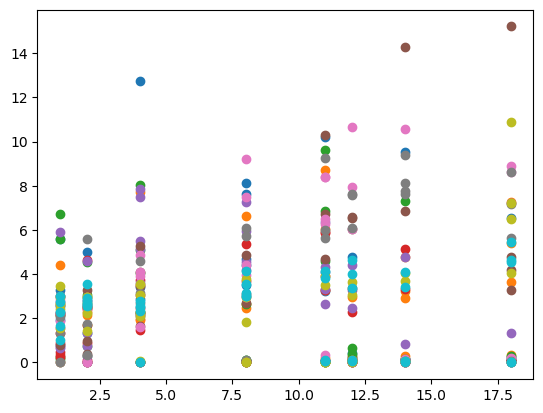

In [553]:
for key in dataset.keys():
    plt.scatter(dataset[key]['trialRewards'],dataset[key]['drinkDurations'])


In [602]:
ZZ0024LR_onset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024LR_low']['spike'],dataset['ZZ0024LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024LR_low']['reward_onset'],dataset['ZZ0024LR_high']['reward_onset']],axis=1))
ZZ0025L_onset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025L_low']['spike'],dataset['ZZ0025L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025L_low']['reward_onset'],dataset['ZZ0025L_high']['reward_onset']],axis=1))
ZZ0025LR_onset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025LR_low']['spike'],dataset['ZZ0025LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025LR_low']['reward_onset'],dataset['ZZ0025LR_high']['reward_onset']],axis=1))
ZZ0024L_onset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024L_low']['spike'],dataset['ZZ0024L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024L_low']['reward_onset'],dataset['ZZ0024L_high']['reward_onset']],axis=1))
HL0023LR_onset_window_spike = get_event_spike(np.concatenate([dataset['HL0023LR_low']['spike'],dataset['HL0023LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['HL0023LR_low']['reward_onset'],dataset['HL0023LR_high']['reward_onset']],axis=1))

In [601]:
ZZ0024LR_offset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024LR_low']['spike'],dataset['ZZ0024LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024LR_low']['reward_offset'],dataset['ZZ0024LR_high']['reward_offset']],axis=1))
ZZ0025L_offset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025L_low']['spike'],dataset['ZZ0025L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025L_low']['reward_offset'],dataset['ZZ0025L_high']['reward_offset']],axis=1))
ZZ0025LR_offset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025LR_low']['spike'],dataset['ZZ0025LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025LR_low']['reward_offset'],dataset['ZZ0025LR_high']['reward_offset']],axis=1))
ZZ0024L_offset_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024L_low']['spike'],dataset['ZZ0024L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024L_low']['reward_offset'],dataset['ZZ0024L_high']['reward_offset']],axis=1))
HL0023LR_offset_window_spike = get_event_spike(np.concatenate([dataset['HL0023LR_low']['spike'],dataset['HL0023LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['HL0023LR_low']['reward_offset'],dataset['HL0023LR_high']['reward_offset']],axis=1))

In [569]:
ZZ0024LR_tone_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024LR_low']['spike'],dataset['ZZ0024LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024LR_low']['tone_onset'],dataset['ZZ0024LR_high']['tone_onset']],axis=1))
ZZ0025L_tone_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025L_low']['spike'],dataset['ZZ0025L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025L_low']['tone_onset'],dataset['ZZ0025L_high']['tone_onset']],axis=1))
ZZ0025LR_tone_window_spike = get_event_spike(np.concatenate([dataset['ZZ0025LR_low']['spike'],dataset['ZZ0025LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0025LR_low']['tone_onset'],dataset['ZZ0025LR_high']['tone_onset']],axis=1))
ZZ0024L_tone_window_spike = get_event_spike(np.concatenate([dataset['ZZ0024L_low']['spike'],dataset['ZZ0024L_high']['spike']],axis=1),
                                                       np.concatenate([dataset['ZZ0024L_low']['tone_onset'],dataset['ZZ0024L_high']['tone_onset']],axis=1))
HL0023LR_tone_window_spike = get_event_spike(np.concatenate([dataset['HL0023LR_low']['spike'],dataset['HL0023LR_high']['spike']],axis=1),
                                                       np.concatenate([dataset['HL0023LR_low']['tone_onset'],dataset['HL0023LR_high']['tone_onset']],axis=1))

In [605]:
mice      = ['ZZ0024-L', 'ZZ0024-LR', 'ZZ0025-L', 'ZZ0025-LR']
# Collect all reward window spike matrices for each mouse
matrices  = [ZZ0024L_onset_window_spike, ZZ0024LR_onset_window_spike, ZZ0025L_onset_window_spike, ZZ0025LR_onset_window_spike]

supermouse_onset = np.concatenate(matrices, axis=0)

lens = np.array([m.shape[0] for m in matrices])
edges = np.cumsum(lens)   

In [594]:
mice      = ['ZZ0024-L', 'ZZ0024-LR', 'ZZ0025-L', 'ZZ0025-LR', 'HL0023-LR']
# Collect all reward window spike matrices for each mouse
matrices  = [ZZ0024L_tone_window_spike, ZZ0024LR_tone_window_spike, ZZ0025L_tone_window_spike, ZZ0025LR_tone_window_spike, HL0023LR_tone_window_spike]

supermouse_tone = np.concatenate(matrices, axis=0)

In [621]:
mice      = ['ZZ0024-L', 'ZZ0024-LR', 'ZZ0025-L', 'ZZ0025-LR', 'HL0023-LR']
# Collect all reward window spike matrices for each mouse
matrices  = [ZZ0024L_offset_window_spike, ZZ0024LR_offset_window_spike, ZZ0025L_offset_window_spike, ZZ0025LR_offset_window_spike, HL0023LR_offset_window_spike]

supermouse_offset = np.concatenate(matrices, axis=0)

In [557]:
def global2local(g_idx, edges=edges, mice=mice):
    """
    Convert global neuron index -> (mouse_name, local_idx)
    """
    i_mouse = np.searchsorted(edges, g_idx, side='right')
    start   = 0 if i_mouse == 0 else edges[i_mouse-1]
    local   = g_idx - start
    return mice[i_mouse], local

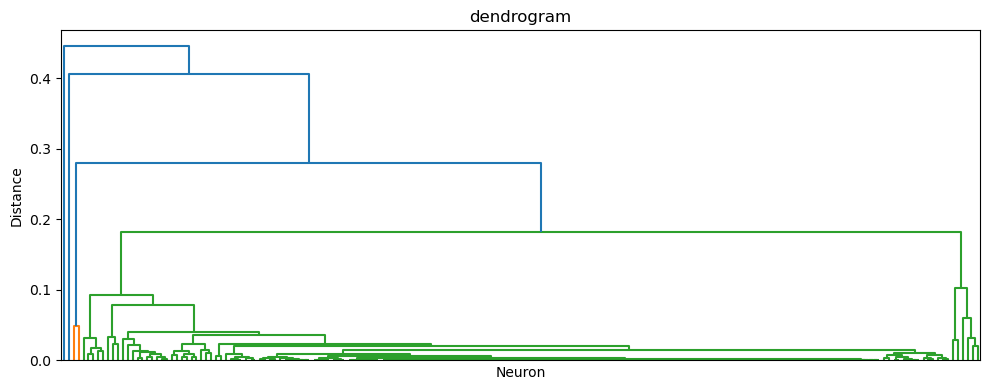

In [643]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from scipy.stats import rankdata
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

def auroc(sample, baseline):
    if len(sample) == 0:
        return 0.5
    combined = np.concatenate([sample, baseline])
    ranks = rankdata(combined)
    n1 = len(sample)
    r1 = ranks[:n1].sum()
    n2 = len(baseline)
    U = r1 - n1 * (n1 + 1) / 2
    return U / (n1 * n2)

def build_features(spikes):
    n_neurons = spikes.shape[0]

    fs = 15
    bin_len = 3
    pre_bins = 0
    post_bins = 10
    total_bins = pre_bins + post_bins

    # Use all reward events, even if incomplete; we'll pad with zeros implicitly
    baseline = np.zeros(spikes.shape[1])

    features = np.zeros((n_neurons, total_bins))
    for bin_i in range(total_bins):
        start_offset = (15 - pre_bins*bin_len) + bin_i * bin_len
        end_offset = start_offset + bin_len
        counts = np.zeros((n_neurons, spikes.shape[1]))
        for ti in range(spikes.shape[1]):
            s_clip =  start_offset
            e_clip = end_offset
            if s_clip < e_clip:
                counts[:, ti] = spikes[:, ti, s_clip:e_clip].sum(axis=1)
            # if window is entirely outside recording bounds, counts remain zeros
        for n in range(n_neurons):
            features[n, bin_i] = auroc(counts[n], baseline)
    return features

features = build_features(HL0023LR_offset_window_spike)

# PCA
pca = PCA(n_components=3)
scores = pca.fit_transform(features)

# Hierarchical clustering
Z = linkage(scores, method="complete", metric="euclidean")
cluster_labels = fcluster(Z, t=5, criterion='maxclust')

# Present results
df = pd.DataFrame({"neuron_id": np.arange(features.shape[0]), "cluster": cluster_labels})

# Dendrogram
plt.figure(figsize=(10,4))
dendrogram(Z, no_labels=True, color_threshold=Z[-3,2])
plt.title("dendrogram")
plt.xlabel("Neuron")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


In [645]:
df.loc[df["cluster"] == 1, "neuron_id"].to_numpy()

array([43, 67])

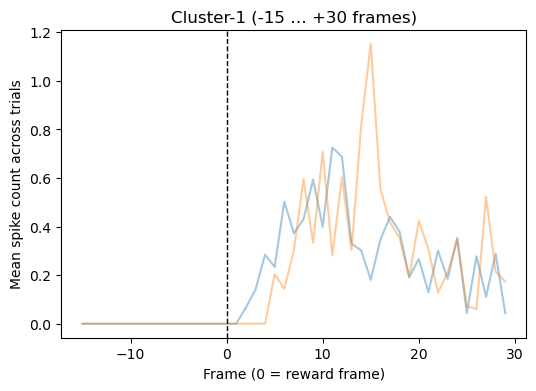

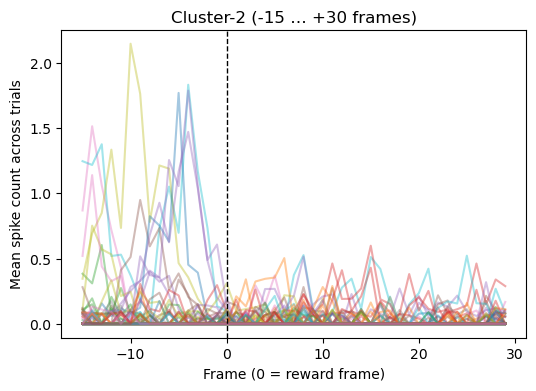

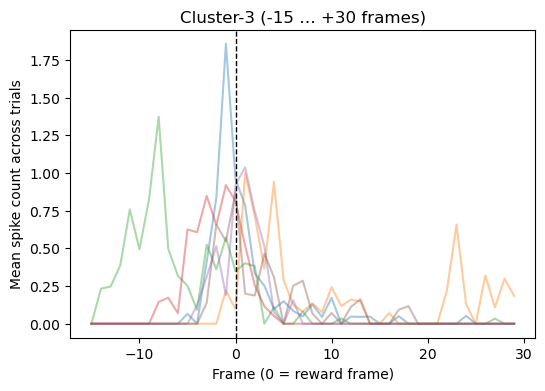

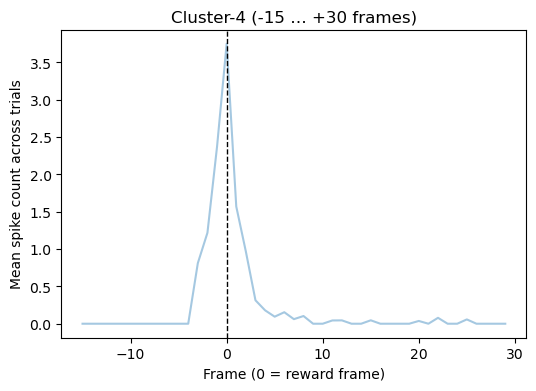

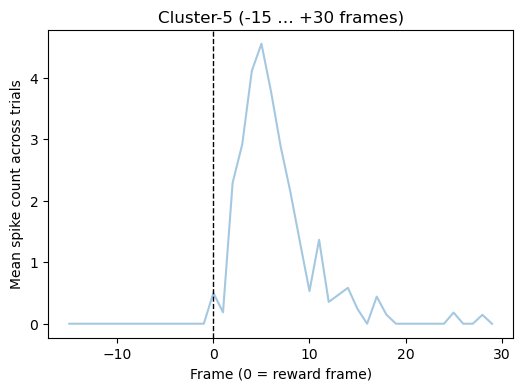

In [644]:
import matplotlib.pyplot as plt
import numpy as np

# cluster = 1
for cluster in range(5):
    neurons_tobe_plotted = df.loc[df["cluster"] == cluster+1, "neuron_id"].to_numpy()

    plt.figure(figsize=(6, 4))
    idx   = np.arange(45)          # 0 … 44
    time  = idx - 15  

    for neuron in neurons_tobe_plotted:
        plt.plot(time, (HL0023LR_offset_window_spike[neuron,:,:].mean(axis=0)), alpha=0.4)     # light lines per neuron

    plt.axvline(x=0,       # x-coordinate
                color='k',  # line color (k = black)
                linestyle='--', 
                linewidth=1)
    plt.title(f"Cluster-{cluster+1} (-15 … +30 frames)")
    plt.xlabel("Frame (0 = reward frame)")
    plt.ylabel("Mean spike count across trials") #(normalized across neurons)
    plt.show()


In [ ]:
sel_neurons = df.loc[df["cluster"] == 4, "neuron_id"].to_numpy()
window = [0,20]

for super_neuron_idx in sel_neurons:
    mouse, neuron_idx = global2local(super_neuron_idx)
    if mouse == 'ZZ0024-L':
        plot_mean_activity(ZZ0024L_low['spike'], ZZ0024L_low['reward_onset'], ZZ0024L_low['trialRewards'], neuron_idx, window, 'low', is_mean_subtraced=True)
        estimate_rp(ZZ0024L_low['spike'], ZZ0024L_low['reward_onset'], ZZ0024L_low['trialRewards'], neuron_idx, window, 'low')
        plot_mean_activity(ZZ0024L_high['spike'], ZZ0024L_high['reward_onset'], ZZ0024L_high['trialRewards'], neuron_idx, window, 'high', is_mean_subtraced=True)
        estimate_rp(ZZ0024L_high['spike'], ZZ0024L_high['reward_onset'], ZZ0024L_high['trialRewards'], neuron_idx, window, 'high')
    elif mouse == 'ZZ0024-LR':
        plot_mean_activity(ZZ0024LR_low['spike'], ZZ0024LR_low['reward_onset'], ZZ0024LR_low['trialRewards'], neuron_idx, window, 'low', is_mean_subtraced=True)
        estimate_rp(ZZ0024LR_low['spike'], ZZ0024LR_low['reward_onset'], ZZ0024LR_low['trialRewards'], neuron_idx, window, 'low')
        plot_mean_activity(ZZ0024LR_high['spike'], ZZ0024LR_high['reward_onset'], ZZ0024LR_high['trialRewards'], neuron_idx, window, 'high', is_mean_subtraced=True)
        estimate_rp(ZZ0024LR_high['spike'], ZZ0024LR_high['reward_onset'], ZZ0024LR_high['trialRewards'], neuron_idx, window, 'high')
    elif mouse == 'ZZ0025-L':
        plot_mean_activity(ZZ0025L_low['spike'], ZZ0025L_low['reward_onset'], ZZ0025L_low['trialRewards'], neuron_idx, window, 'low', is_mean_subtraced=True)
        estimate_rp(ZZ0025L_low['spike'], ZZ0025L_low['reward_onset'], ZZ0025L_low['trialRewards'], neuron_idx, window, 'low')
        plot_mean_activity(ZZ0025L_high['spike'], ZZ0025L_high['reward_onset'], ZZ0025L_high['trialRewards'], neuron_idx, window, 'high', is_mean_subtraced=True)
        estimate_rp(ZZ0025L_high['spike'], ZZ0025L_high['reward_onset'], ZZ0025L_high['trialRewards'], neuron_idx, window, 'high')
    elif mouse == 'ZZ0025-LR':
        plot_mean_activity(ZZ0025LR_low['spike'], ZZ0025LR_low['reward_onset'], ZZ0025LR_low['trialRewards'], neuron_idx, window, 'low', is_mean_subtraced=True)
        estimate_rp(ZZ0025LR_low['spike'], ZZ0025LR_low['reward_onset'], ZZ0025LR_low['trialRewards'], neuron_idx, window, 'low')
        plot_mean_activity(ZZ0025LR_high['spike'], ZZ0025LR_high['reward_onset'], ZZ0025LR_high['trialRewards'], neuron_idx, window, 'high', is_mean_subtraced=True)
        estimate_rp(ZZ0025LR_high['spike'], ZZ0025LR_high['reward_onset'], ZZ0025LR_high['trialRewards'], neuron_idx, window, 'high')

In [454]:
reward_excited_neurons = np.concatenate([df.loc[df["cluster"] == 1, "neuron_id"].to_numpy(), df.loc[df["cluster"] == 3, "neuron_id"].to_numpy(), df.loc[df["cluster"] == 4, "neuron_id"].to_numpy()])
reward_excited_neurons

array([   0,  635,  884,  889,  932,  240,  894,  930,  952,   29,   37,
         44,   55,   66,  221,  620,  655,  682,  687,  725,  727,  815,
        917,  936, 1003, 1032])

In [ ]:
 29,  66, 280, 341, 635, 637, 662, 663, 894, 917, 930, 936]

In [483]:
def get_RPEneuronidx(data, neurons):    
    neural_data = data['spike']
    reward_onset = data['reward_onset']
    trialRewards = data['trialRewards']
    drinkDurations = data['drinkDurations']
    tone_onset = data['tone_onset']

    RPE_neurons_id = []
    for neuron in neurons:
        meanFR_reward = np.zeros(40)
        reward_timepoints = np.where(reward_onset > 0)[1]

        tone_timepoints = np.where(tone_onset > 0)[1]

        for i in range(40):
            meanFR_reward[i] = neural_data[neuron, reward_timepoints[i]:reward_timepoints[i]+30].mean(axis=0)

        trialRewards_constant = sm.add_constant(trialRewards)

        model = sm.OLS(meanFR_reward, trialRewards_constant).fit()
        if model.pvalues[1] < 0.05:
            RPE_neurons_id.append(neuron)

    return RPE_neurons_id

sel_neurons = []
for reward_excited_neuron in reward_excited_neurons:
    mouse, neuron_idx = global2local(reward_excited_neuron)
    if mouse == 'ZZ0024-L':
        sel_neurons.append(neuron_idx)
sel_neurons = np.array(sel_neurons).flatten()

data_high = ZZ0024L_high
data_low = ZZ0024L_low

RPEneuron_low = get_RPEneuronidx(data_low, sel_neurons)
RPEneuron_high = get_RPEneuronidx(data_high, sel_neurons)

print(f"RPEneuron_high: {RPEneuron_high}")
print(f'RPEneuron_low: {RPEneuron_low}')


RPEneuron_high: [29, 55]
RPEneuron_low: [37]


/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_62364/3143076736.py:83: RuntimeWarning: invalid value encountered in divide
  return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)


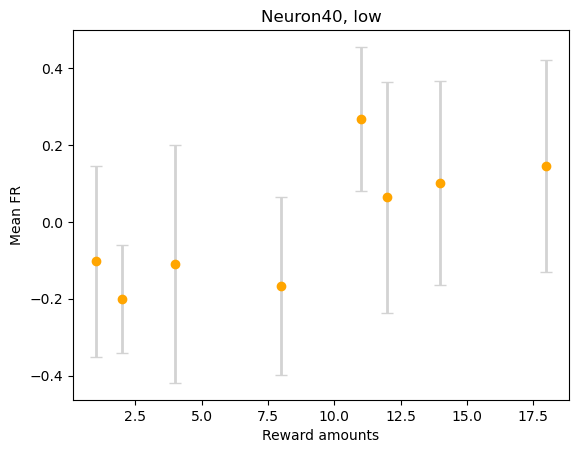

Trained expectation:low
Fitted expectation: 8.659918602052077



/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_62364/3143076736.py:83: RuntimeWarning: invalid value encountered in divide
  return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)


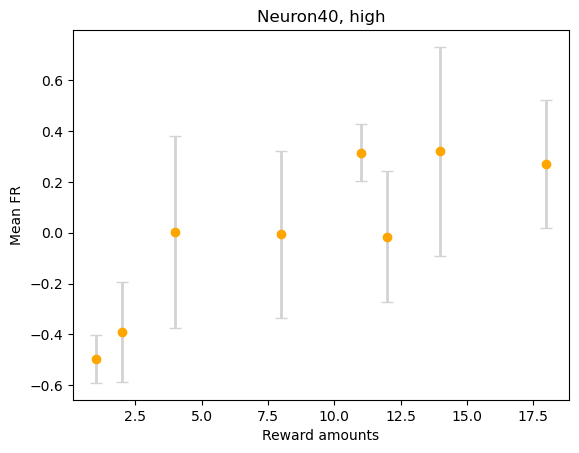

Trained expectation:high
Fitted expectation: 4.079587434269684



In [482]:
neuron_idx = 40
plot_mean_activity(ZZ0024LR_low['spike'], ZZ0024LR_low['reward_onset'], ZZ0024LR_low['trialRewards'], neuron_idx, window, 'low', is_mean_subtraced=True)
estimate_rp(ZZ0024LR_low['spike'], ZZ0024LR_low['reward_onset'], ZZ0024LR_low['trialRewards'], neuron_idx, window, 'low')
plot_mean_activity(ZZ0024LR_high['spike'], ZZ0024LR_high['reward_onset'], ZZ0024LR_high['trialRewards'], neuron_idx, window, 'high', is_mean_subtraced=True)
estimate_rp(ZZ0024LR_high['spike'], ZZ0024LR_high['reward_onset'], ZZ0024LR_high['trialRewards'], neuron_idx, window, 'high')

In [148]:
data = ZZ0024LR_high

expectancy_neurons = df.loc[df["cluster"] == 5, "neuron_id"].to_numpy()

neural_data = data['spike']
reward_onset = data['reward_onset']
trialRewards = data['trialRewards']
drinkDurations = data['drinkDurations']
tone_onset = data['tone_onset']

meanFR_reward = np.zeros([neural_data.shape[0], 40])
reward_timepoints = np.where(reward_onset > 0)[1]

tone_timepoints = np.where(tone_onset > 0)[1]

for i in range(40):
    meanFR_reward[:,i] = neural_data[:, reward_timepoints[i]-15:reward_timepoints[i]].mean(axis=1)


drinkDurations_constant = sm.add_constant(drinkDurations)

expectancy_neurons = select_RPEneurons_GLM(meanFR_reward, drinkDurations_constant, is_pyglm=True)

/Users/fgs/opt/anaconda3/envs/ms_analysis/lib/python3.12/site-packages/pyglmnet/pyglmnet.py:863: UserWarning: Reached max number of iterations without convergence.
  warnings.warn(
/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_62364/2597042431.py:170: RuntimeWarning: divide by zero encountered in divide
  dev_null = 2 * np.sum(y_test * np.log((y_test + eps) / mu_null) - (y_test - mu_null))
/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_62364/2597042431.py:170: RuntimeWarning: invalid value encountered in multiply
  dev_null = 2 * np.sum(y_test * np.log((y_test + eps) / mu_null) - (y_test - mu_null))


In [ ]:
### Smooth binary reward onset using exponential decay function
tau = 30
kernel_length = int(6 * tau)
if kernel_length % 2 == 0:
    kernel_length += 1  # ensure odd length for symmetry

# Create the kernel over 0 to kernel_length frames.
t_kernel = np.arange(kernel_length)
exp_kernel = np.exp(-t_kernel / tau)


n_basis = 13             # Number of basis functions
window_length_frames = 30  # For example, a window of 30 frames (which is 1 second at 30 fps)
dt = 1                   # Since the data is frame-based, each unit represents one frame

# Create the basis functions
t, basis_set = create_raised_cosine_basis(n_basis, window_length_frames, dt)
design_matrix_low = convolve_event_with_basis(z_score(data_low['reward_onset'].flatten(),axis=0), basis_set)
# design_matrix_low = sm.add_constant(z_score(data_low['reward_onset'].flatten(),axis=0))


design_matrix_high = convolve_event_with_basis(z_score(data_high['reward_onset'].flatten(),axis=0), basis_set)
# design_matrix_high = sm.add_constant(z_score(data_high['reward_onset'].flatten(),axis=0))


RPEneurons_high = select_RPEneurons_GLM(data_high['spike'], design_matrix_high)
RPEneurons_low = select_RPEneurons_GLM(data_low['spike'], design_matrix_low)

# RPEneurons_high_linear = select_RPEneurons_linearRegression(data_high['spike'], data_high['reward_onset'], data_high['trialRewards'])
# RPEneurons_low_linear = select_RPEneurons_linearRegression(data_low['spike'], data_low['reward_onset'], data_low['trialRewards'])

In [104]:
np.save('/Users/fgs/HMLworkplace/Arena_analysis/temp/spike_highsession.npy', data_high['spike'])
np.save('/Users/fgs/HMLworkplace/Arena_analysis/temp/spike_lowsession.npy', data_low['spike'])
np.save('/Users/fgs/HMLworkplace/Arena_analysis/temp/reward_onset_highsession.npy', data_high['reward_onset'])
np.save('/Users/fgs/HMLworkplace/Arena_analysis/temp/reward_onset_lowsession.npy', data_low['reward_onset'])

In [169]:
for neuron_idx in [2, 3, 4, 7, 38, 58, 70, 98, 101, 107, 186, 228]:
    estimate_rp(data_high['spike'], data_high['reward_onset'], data_high['trialRewards'], neuron_idx)
    estimate_rp(data_low['spike'], data_low['reward_onset'], data_low['trialRewards'], neuron_idx)

Expectation: 5.513819904082467
Negative slope: -0.14042845350847175
Positive slope: -0.026610477281045437
Expectation: 7.999999986857264
Negative slope: -0.03004845900822551
Positive slope: -0.0017108375944193271
Expectation: 11.188057996746913
Negative slope: -0.01522159000262492
Positive slope: -0.06319152743733714
Expectation: 17.996180753213128
Negative slope: -0.006640853479739949
Positive slope: -143.63671861701147
Expectation: 13.999999998578595
Negative slope: 0.018981527382853795
Positive slope: 0.1532679928923754
Expectation: 10.999829371810124
Negative slope: 0.0009295925262122717
Positive slope: -0.058907550614195725
Expectation: 17.994142279158815
Negative slope: 0.004389592334106033
Positive slope: 39.694747243667635
Expectation: 9.416177781142787
Negative slope: -0.013136191228734639
Positive slope: -0.03864779934377647
Expectation: 17.999637439831204
Negative slope: -0.0012546864912560227
Positive slope: -258.1536038150964
Expectation: 10.999999998226325
Negative slope:

/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_84802/2747176729.py:87: RuntimeWarning: invalid value encountered in divide
  return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)


Expectation: 1.9999999904999115
Negative slope: 0.05791298157881467
Positive slope: -0.00419767650360781
Expectation: 2.8622590421171714
Negative slope: -0.24651297320405524
Positive slope: -0.007686129391749018
Expectation: 22.657105284392227
Negative slope: -2.9708551253854515e-05
Positive slope: -6.351062326943334
Expectation: 13.540123848642333
Negative slope: -0.014829725334157818
Positive slope: -0.1317666775670706
Expectation: 5.130104148281874
Negative slope: 0.06359681017430595
Positive slope: 0.011016351586023846
Expectation: 32.928379419293414
Negative slope: -2.427716948751415e-05
Positive slope: 11.663952208368801
Expectation: 3.999999995423141
Negative slope: -0.31816991796383753
Positive slope: -0.03130193586635788
Expectation: 5.390751330913361
Negative slope: -0.2860353382779066
Positive slope: -0.05977873180954337
Expectation: -123.1840368031782
Negative slope: 72.22990264717068
Positive slope: 7.113601827582606e-06
Expectation: 11.000387830489359
Negative slope: 0.01

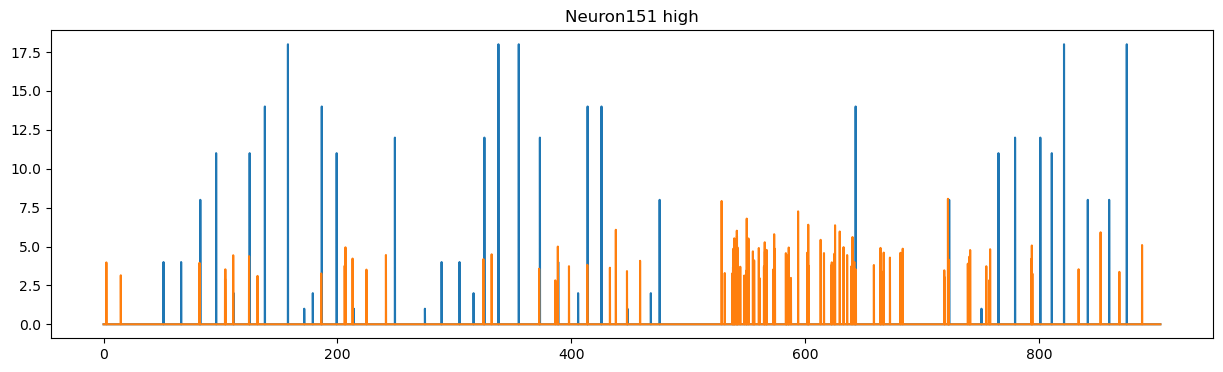

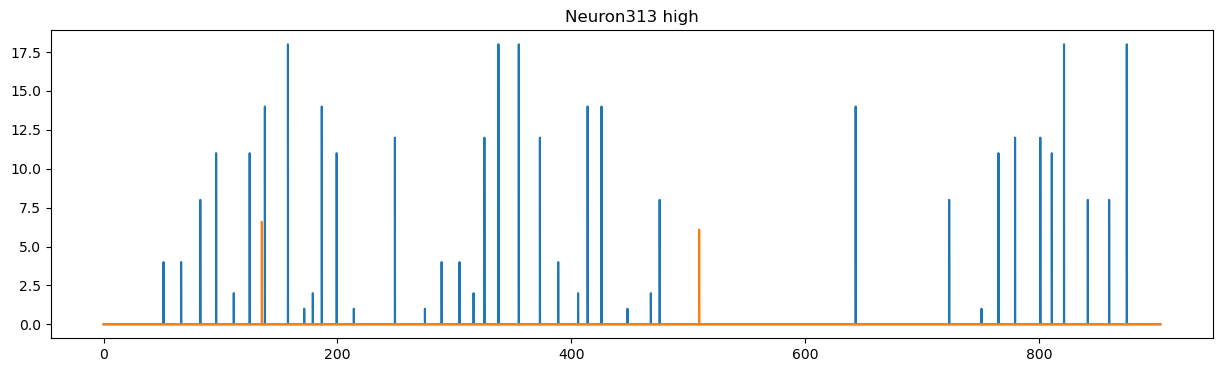

In [173]:
for neuron_idx in [151,313]:
    time = np.arange(data_high['spike'].shape[1])/15
    # time = np.arange(1000)/30
    plt.figure(figsize=(15, 4))

    plt.plot(time, (data_high['reward_onset'].T), label='reward')
    plt.plot(time, (data_high['spike'][neuron_idx,:]), label='FR')
    plt.title(f'Neuron{neuron_idx} high')

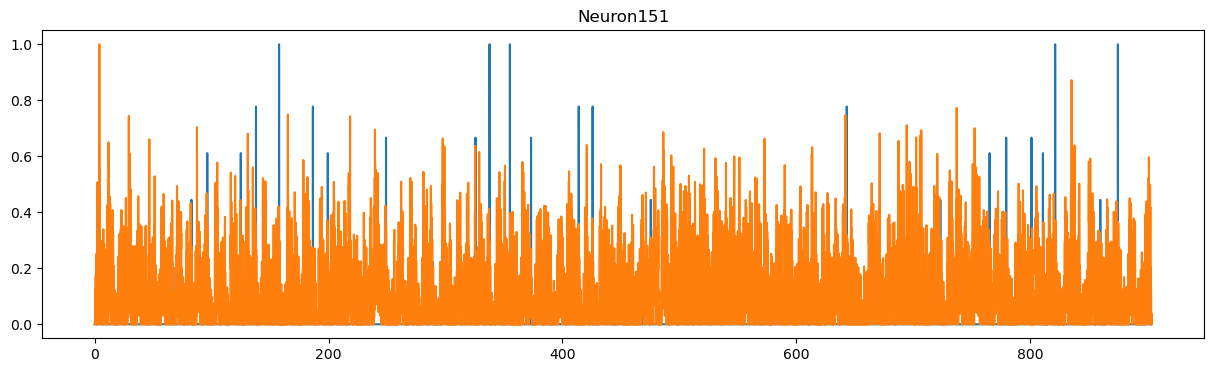

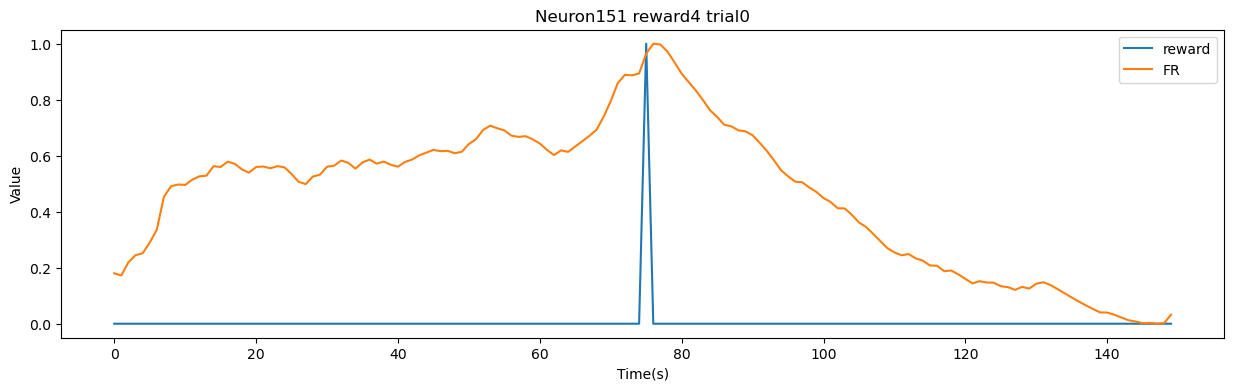

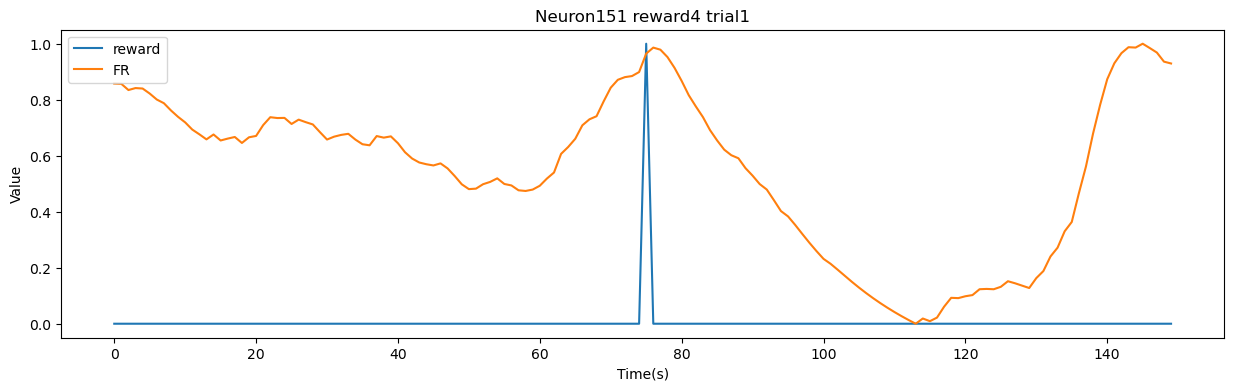

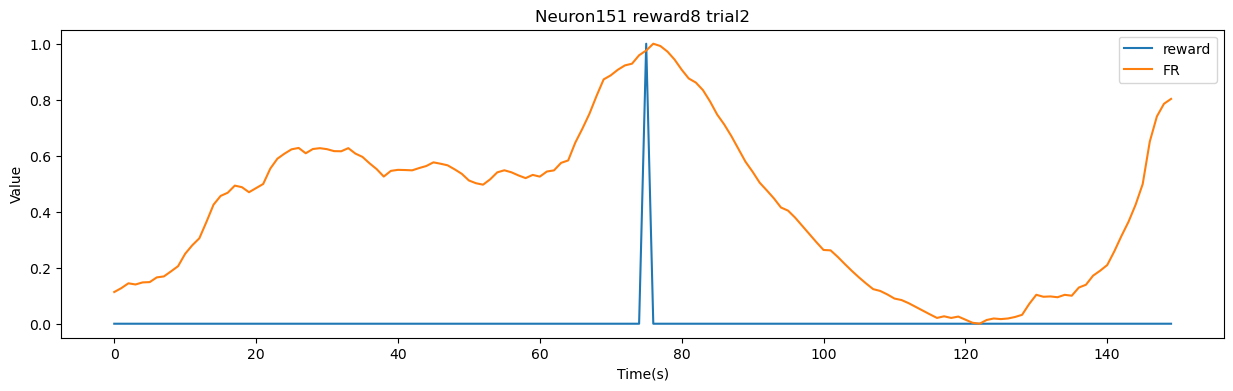

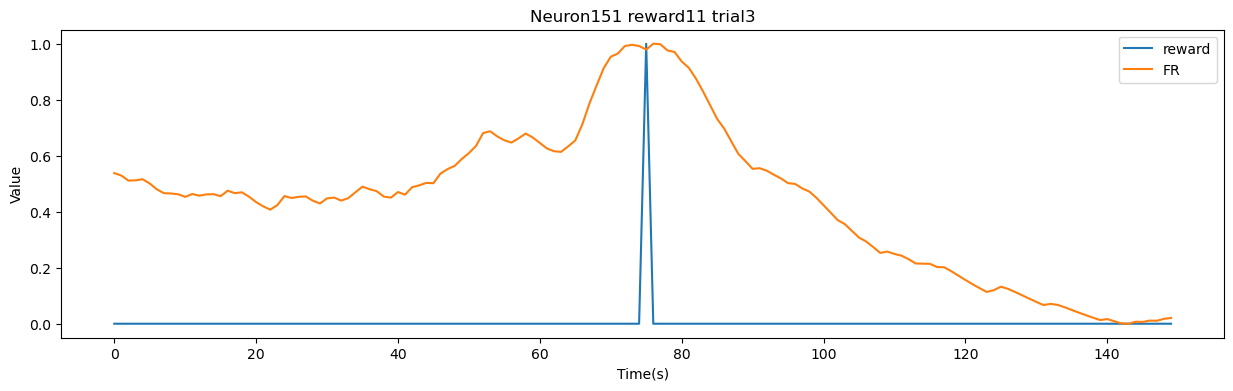

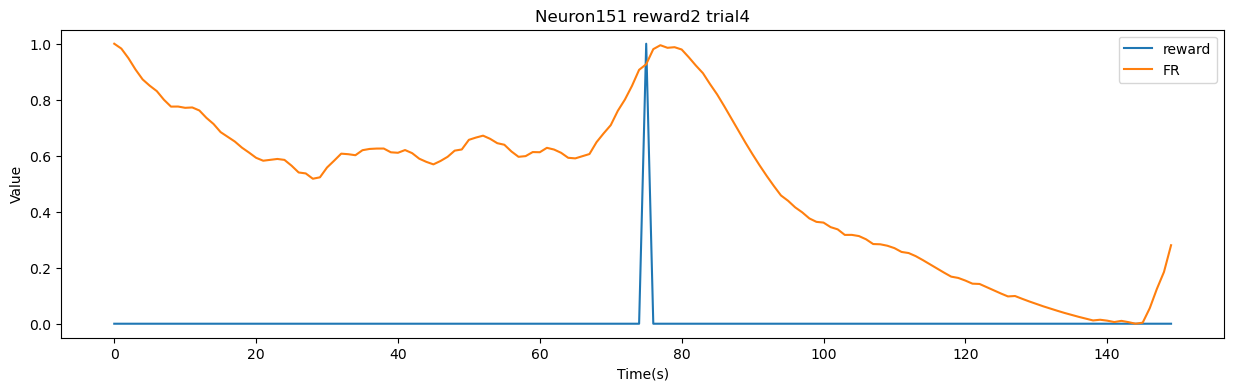

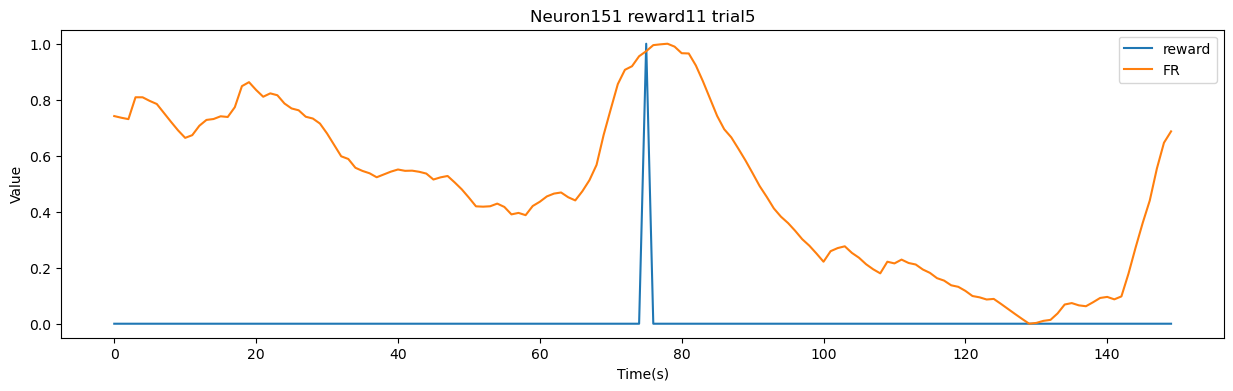

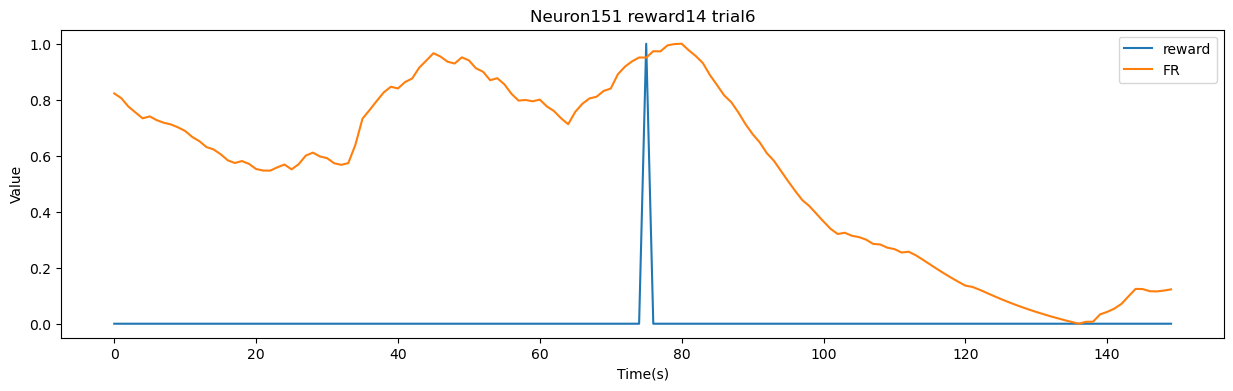

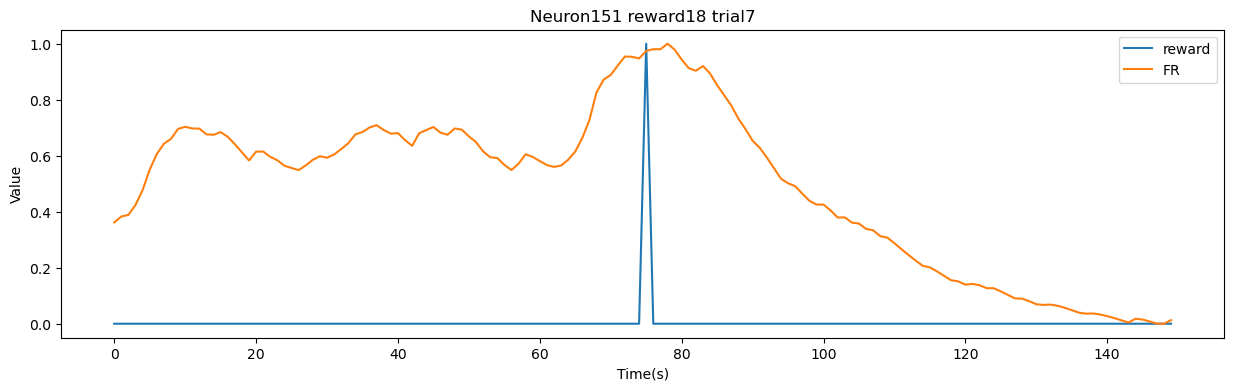

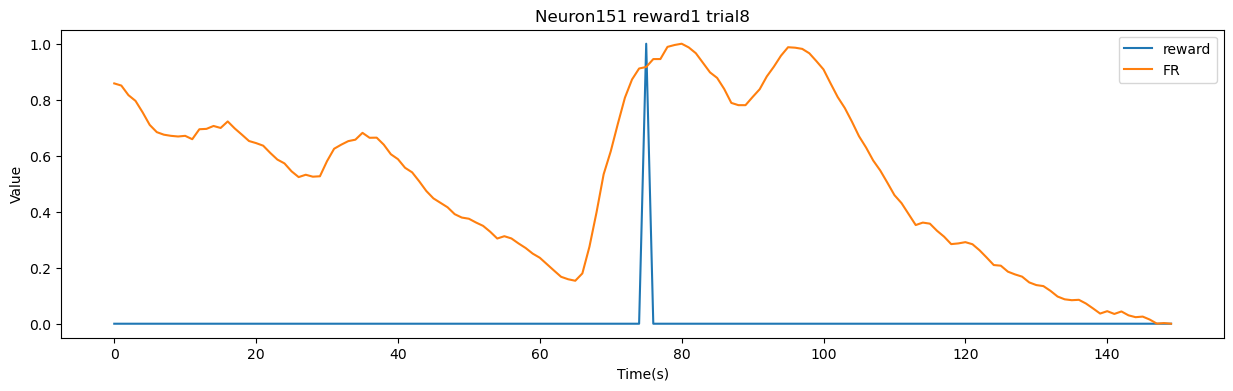

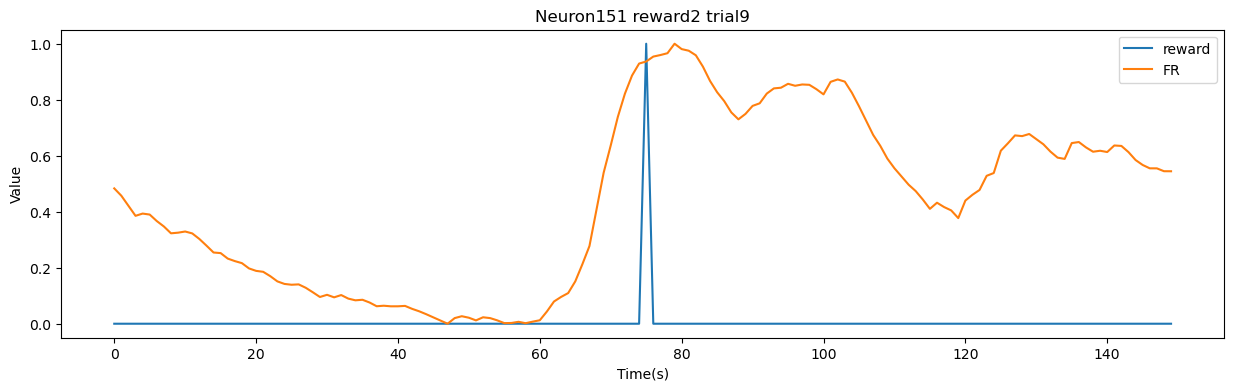

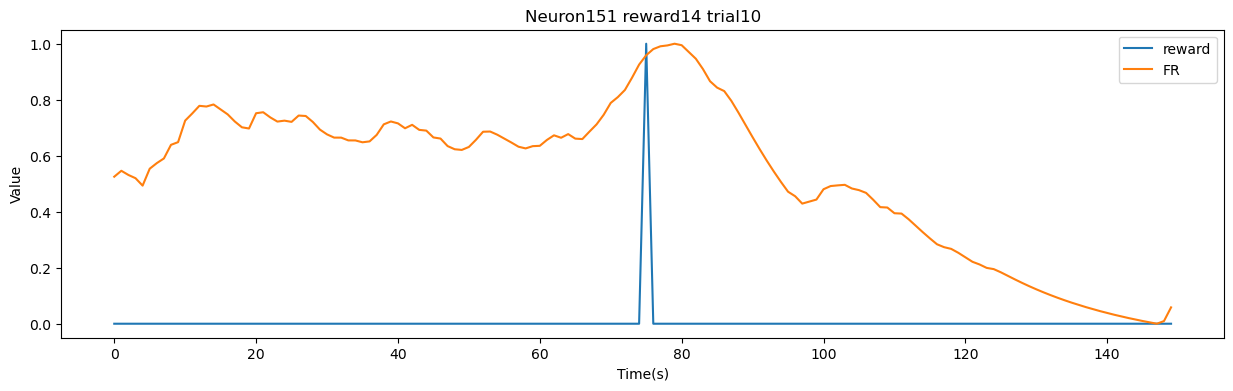

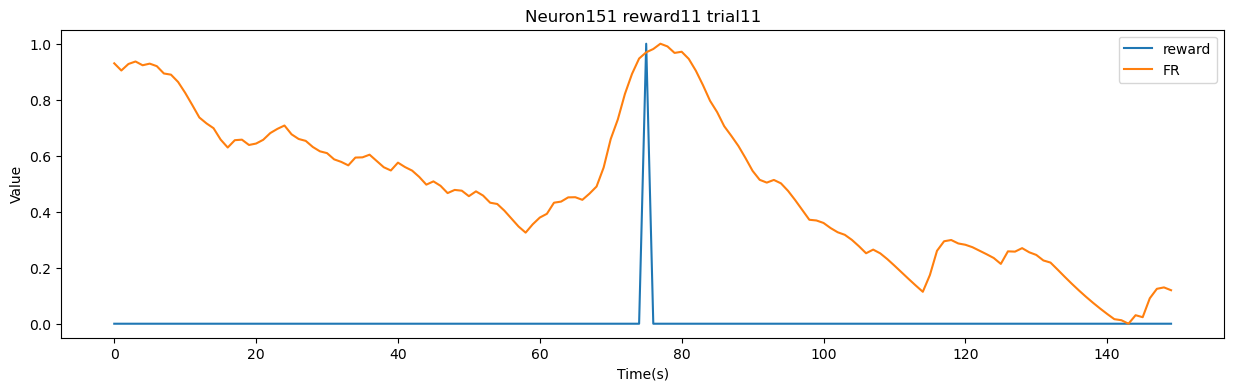

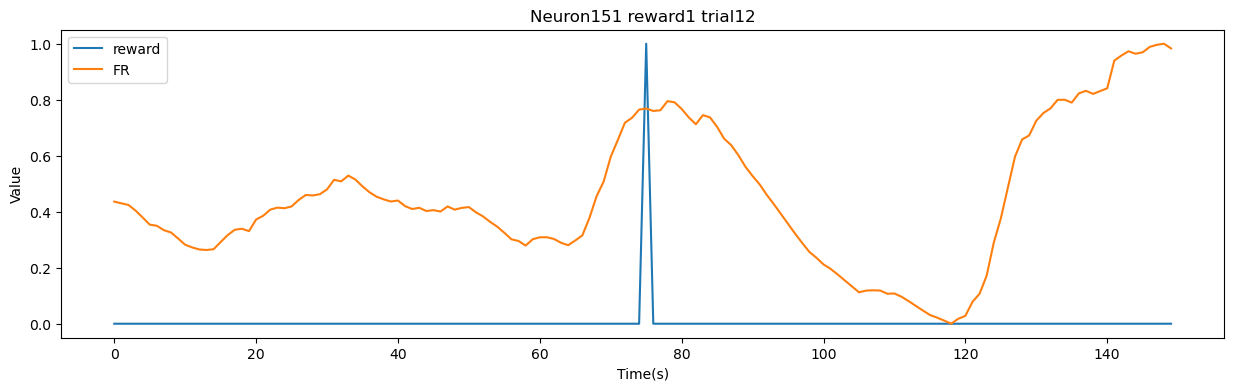

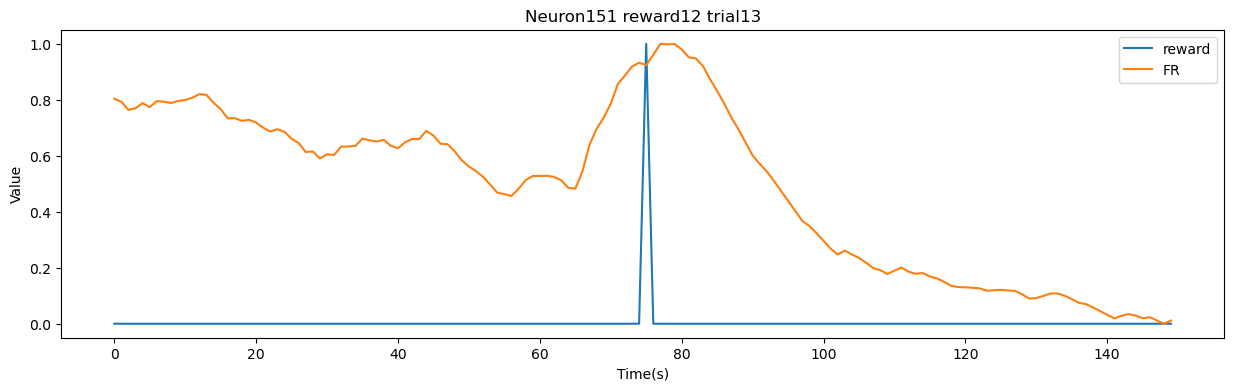

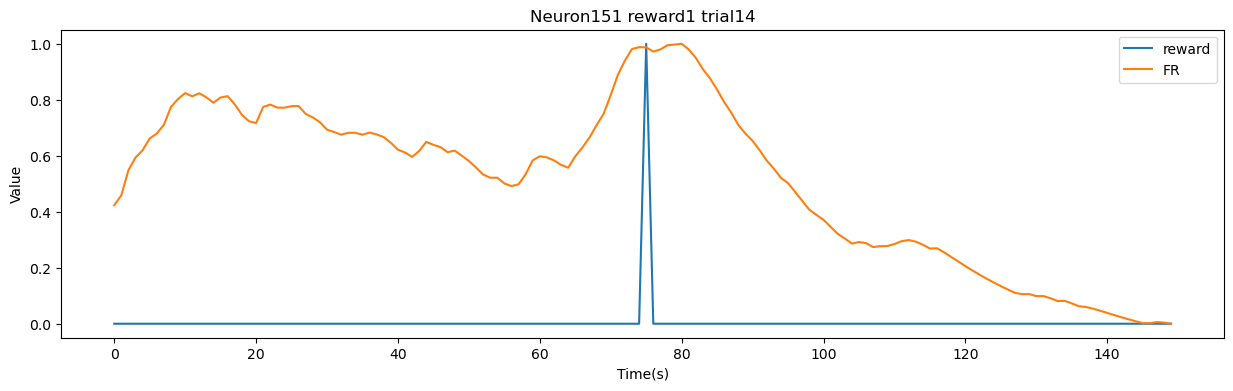

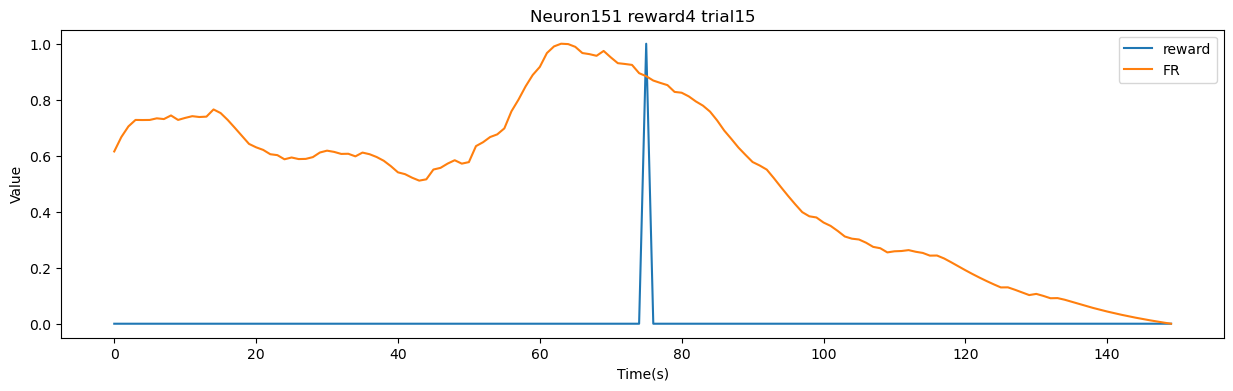

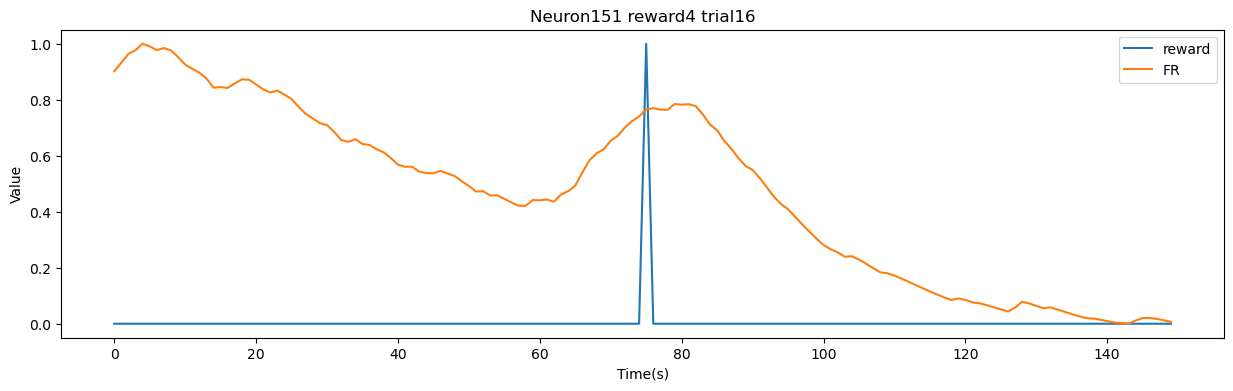

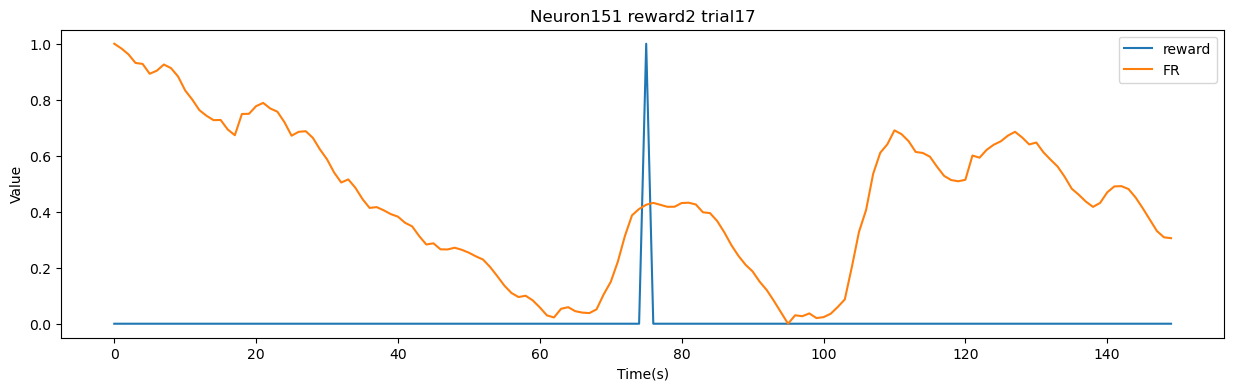

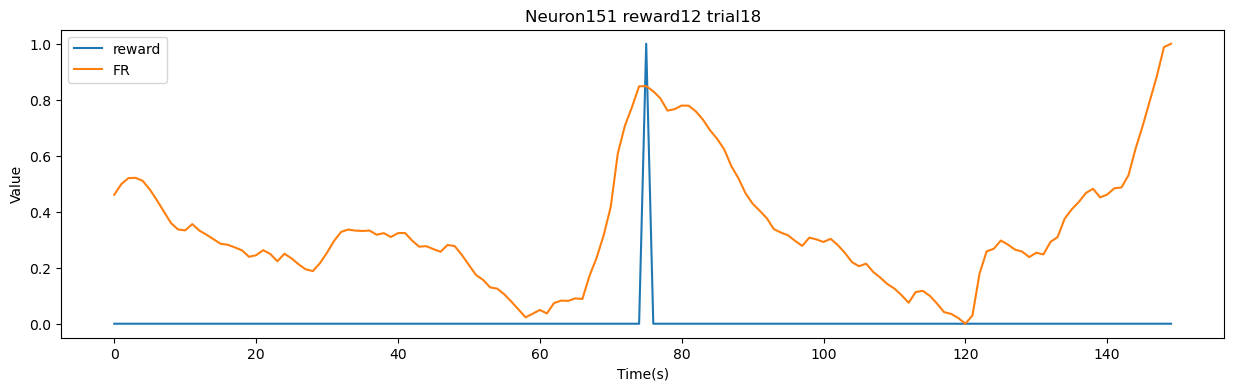

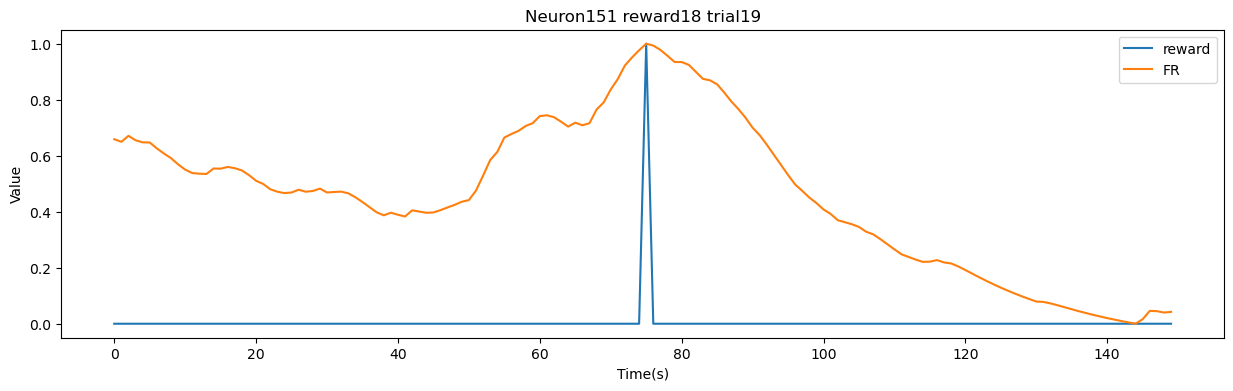

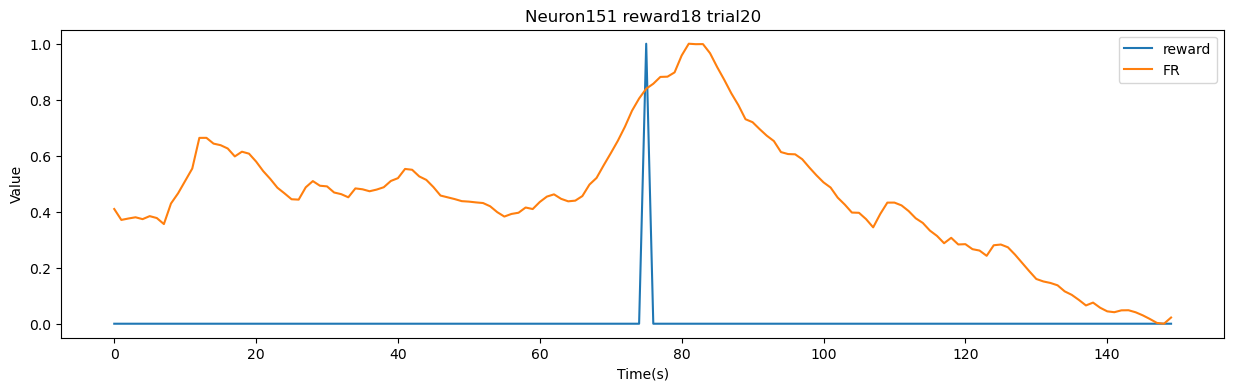

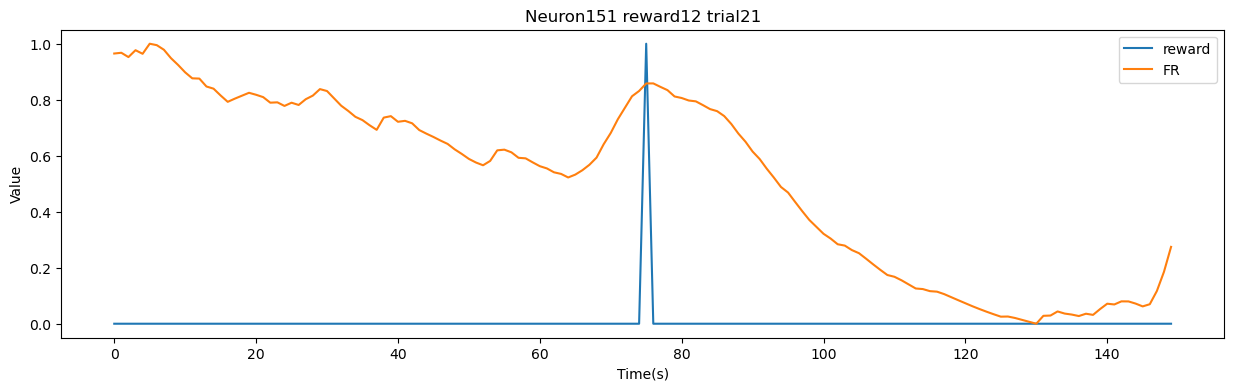

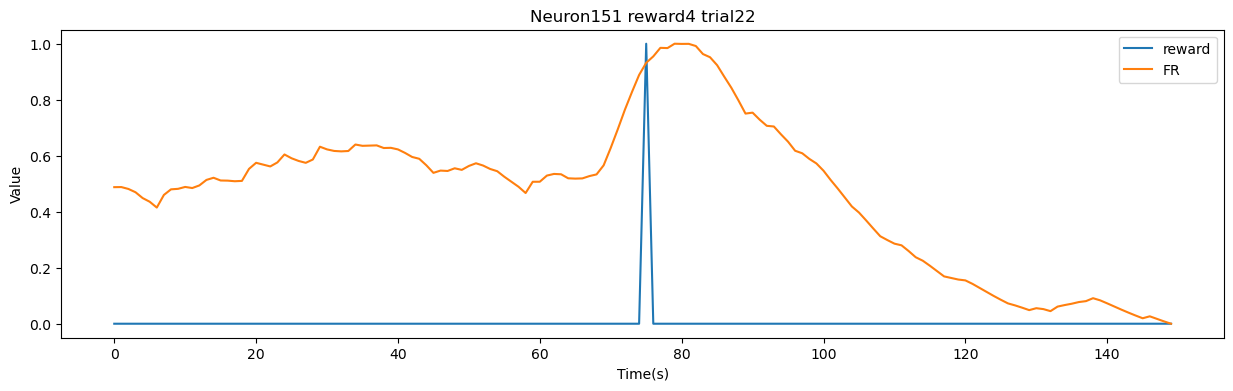

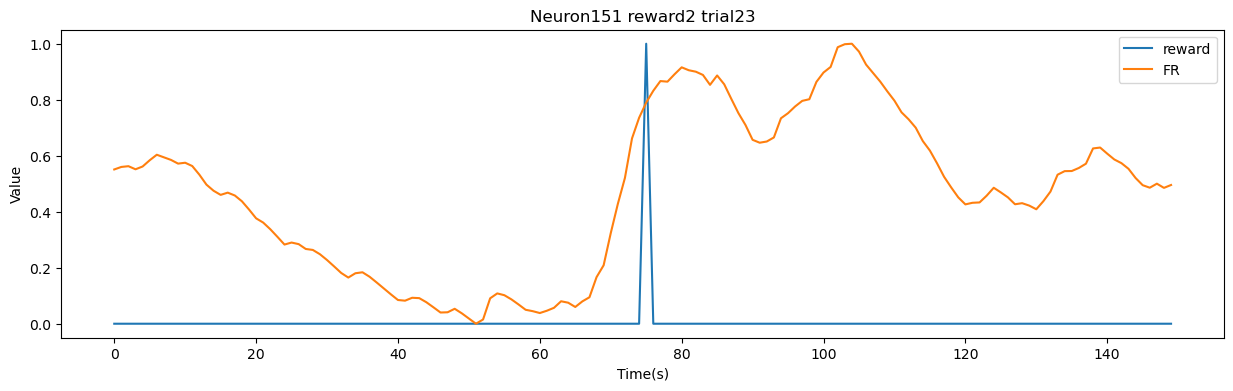

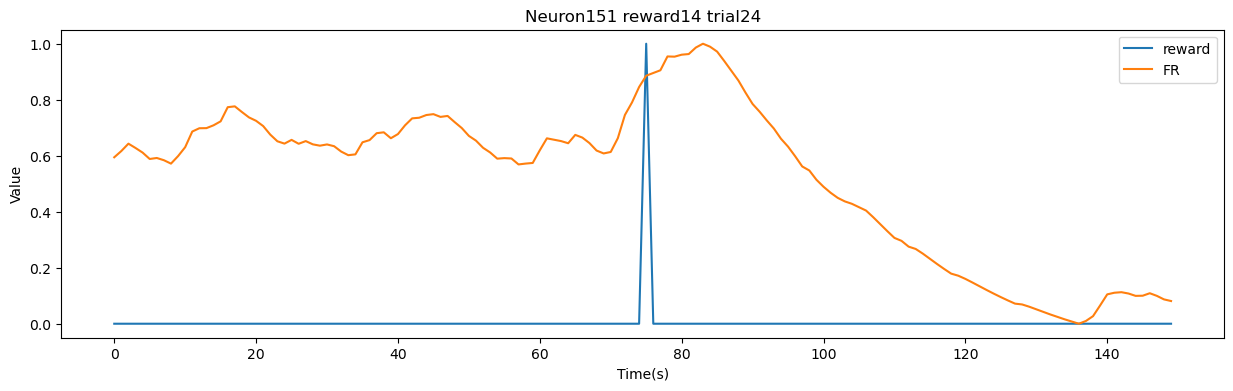

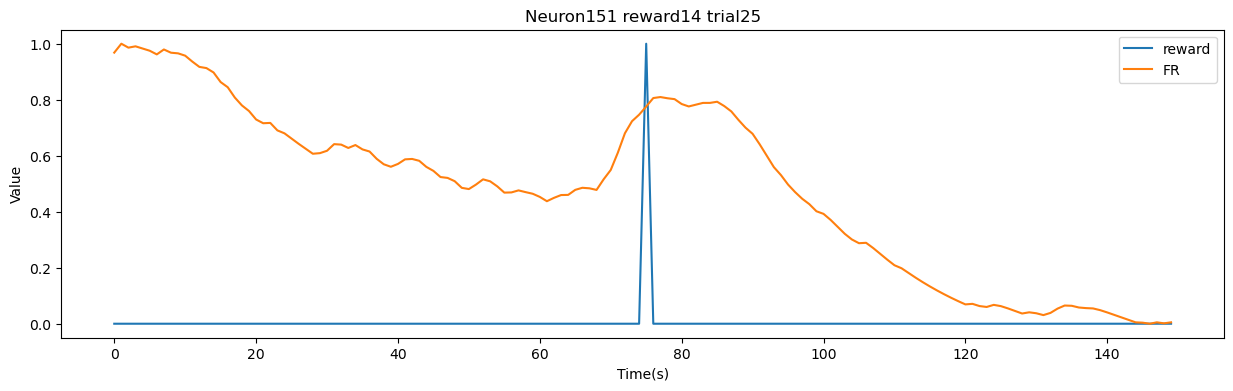

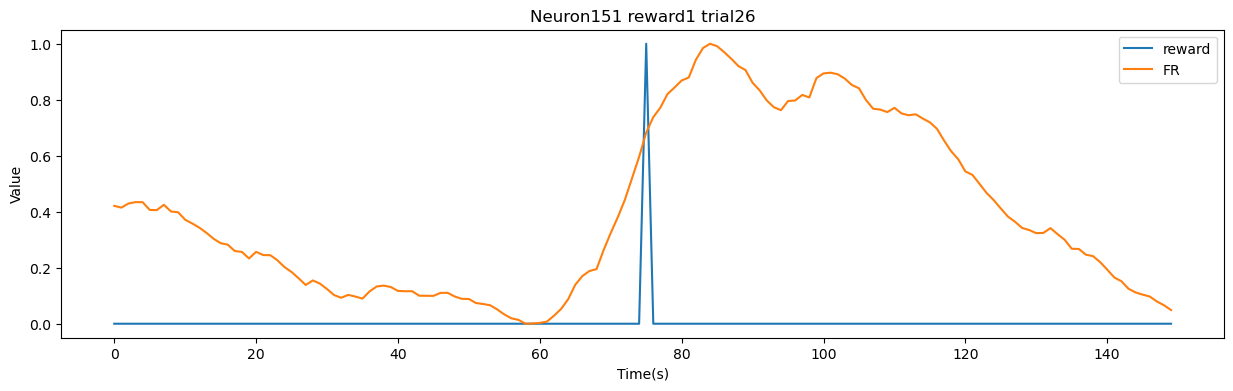

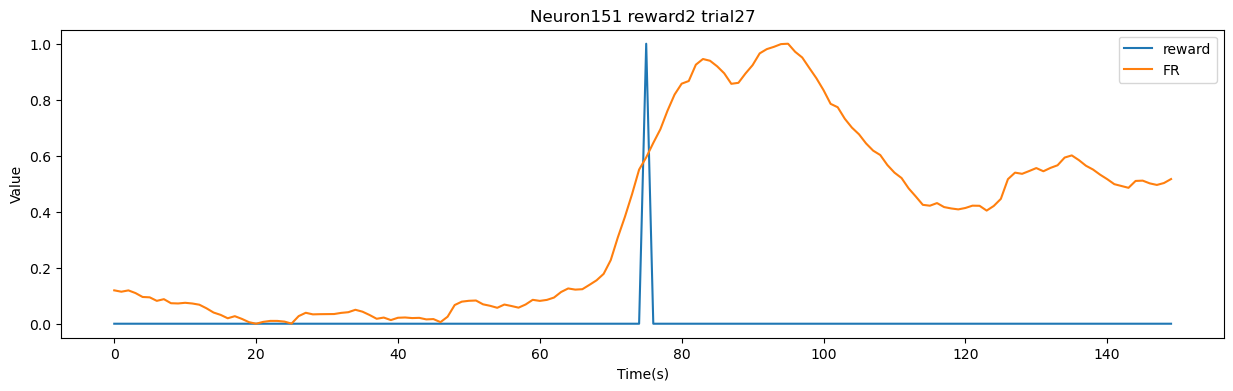

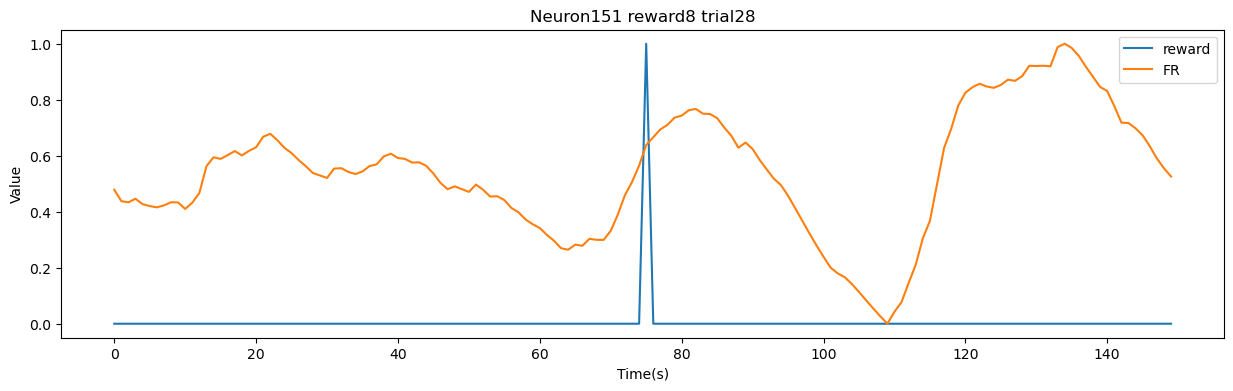

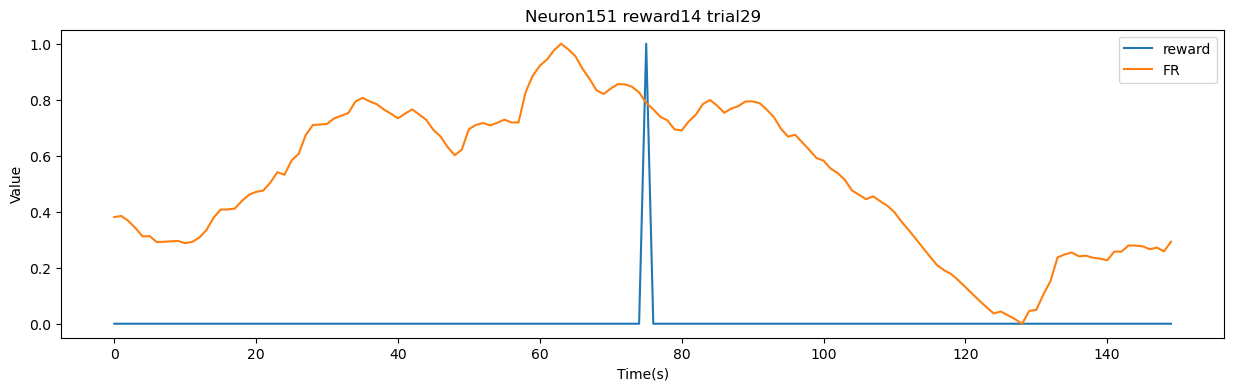

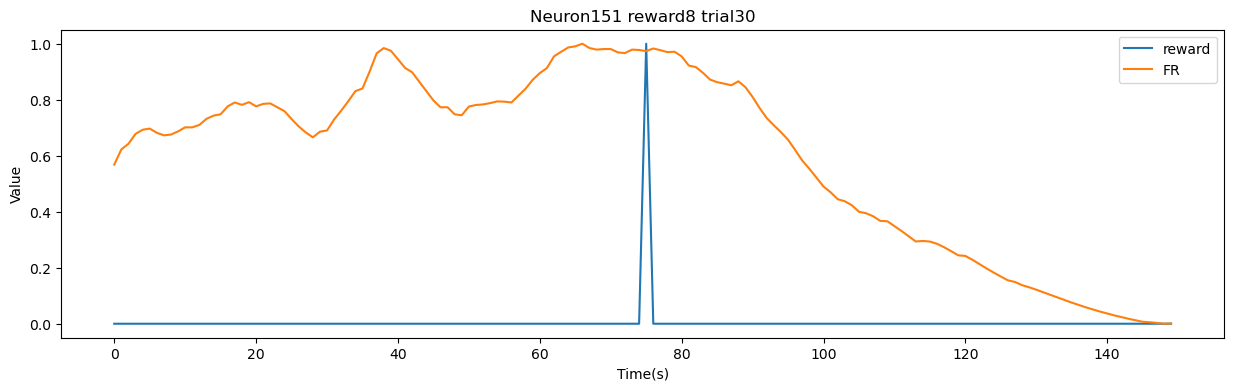

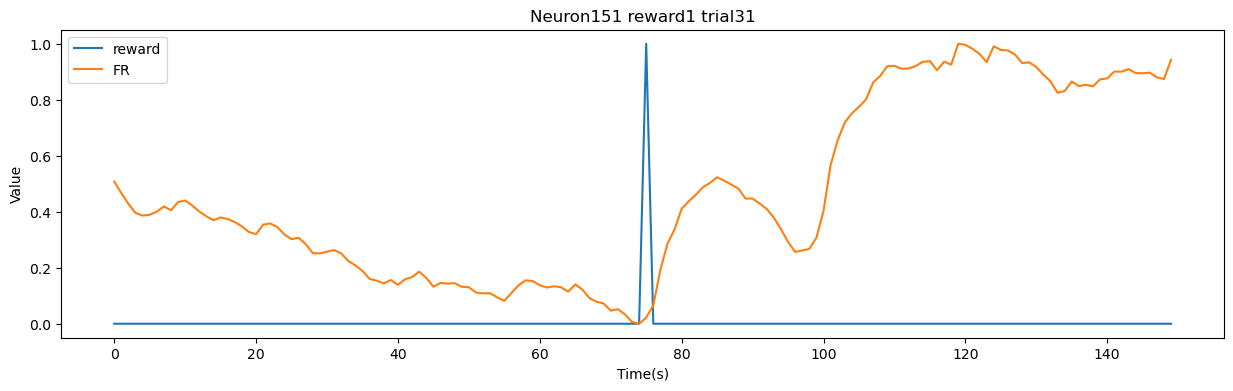

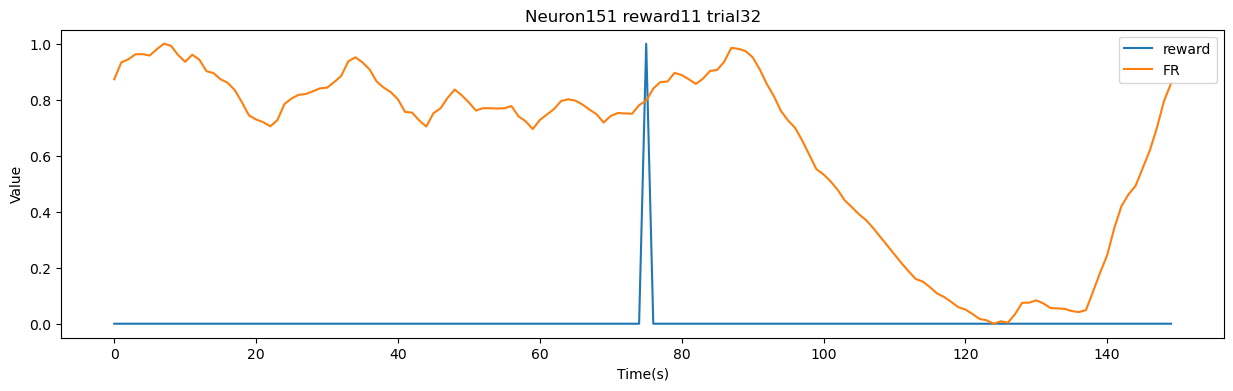

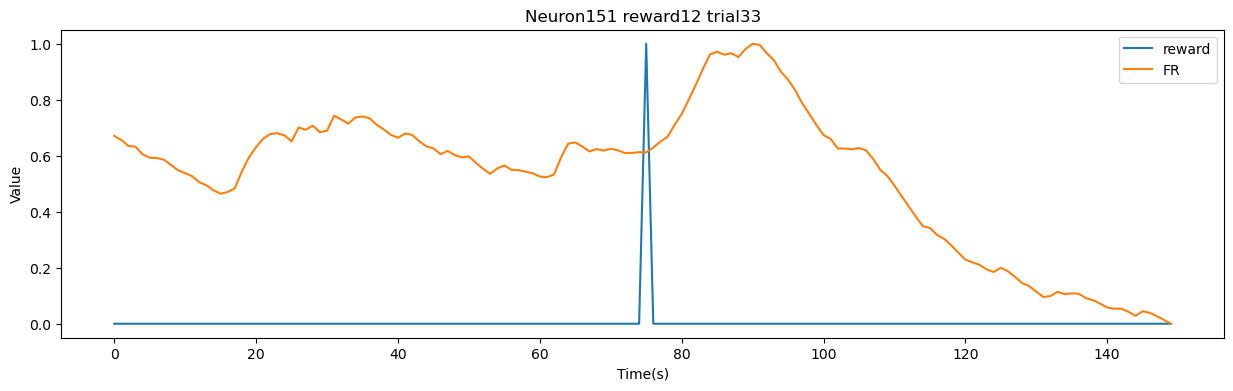

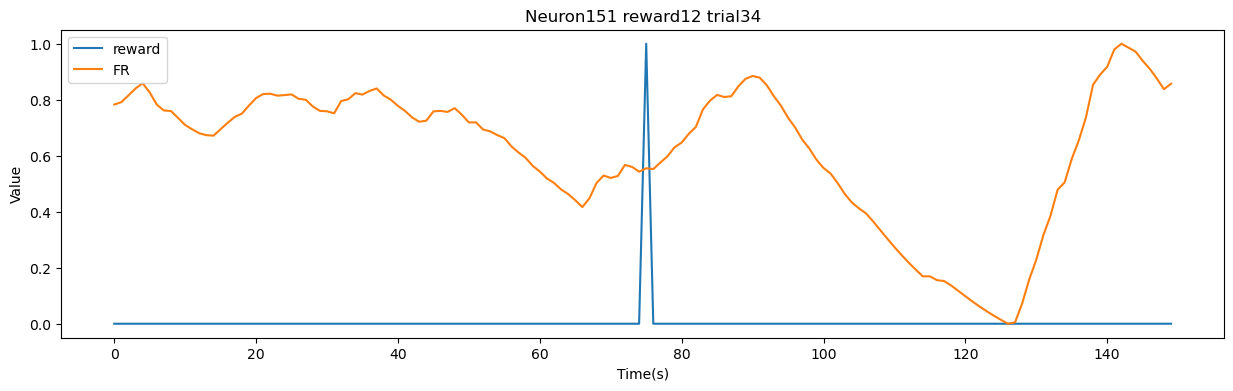

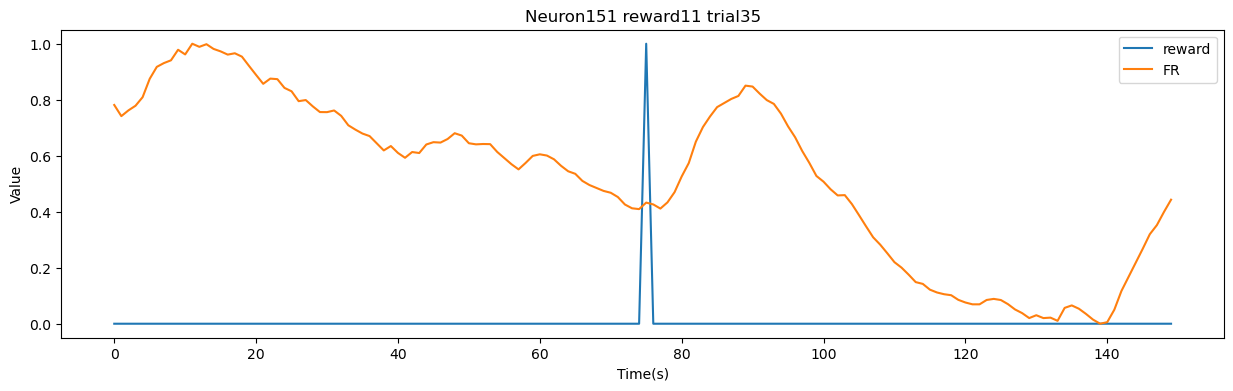

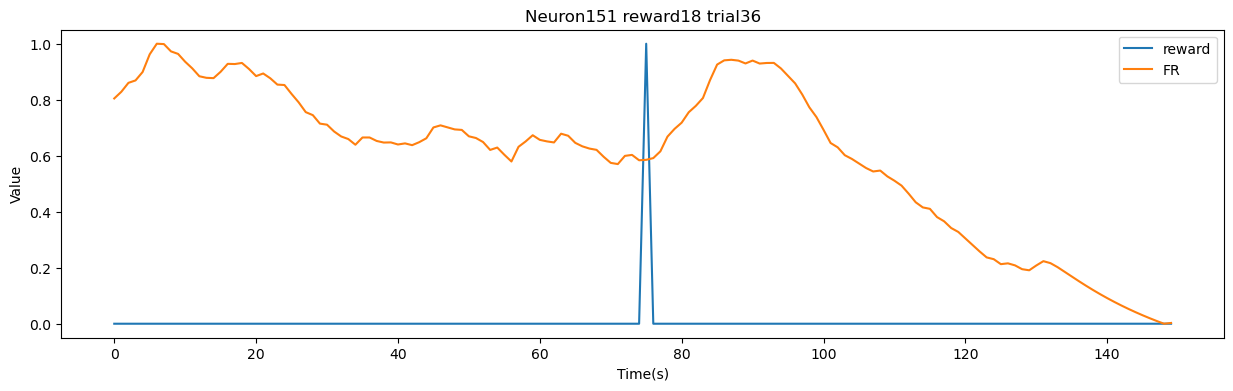

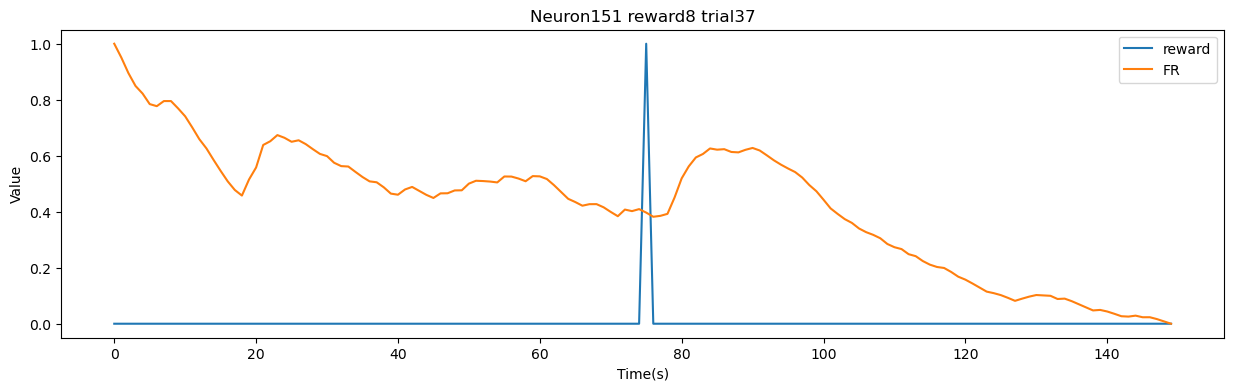

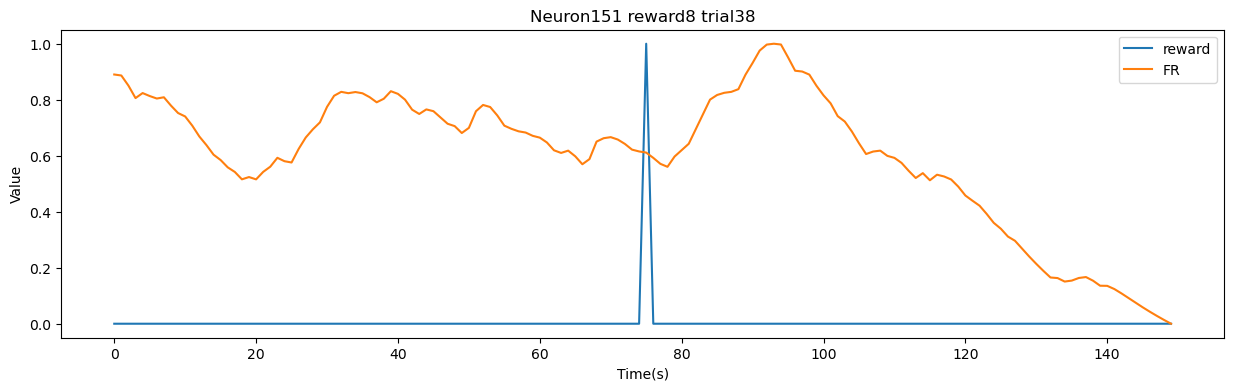

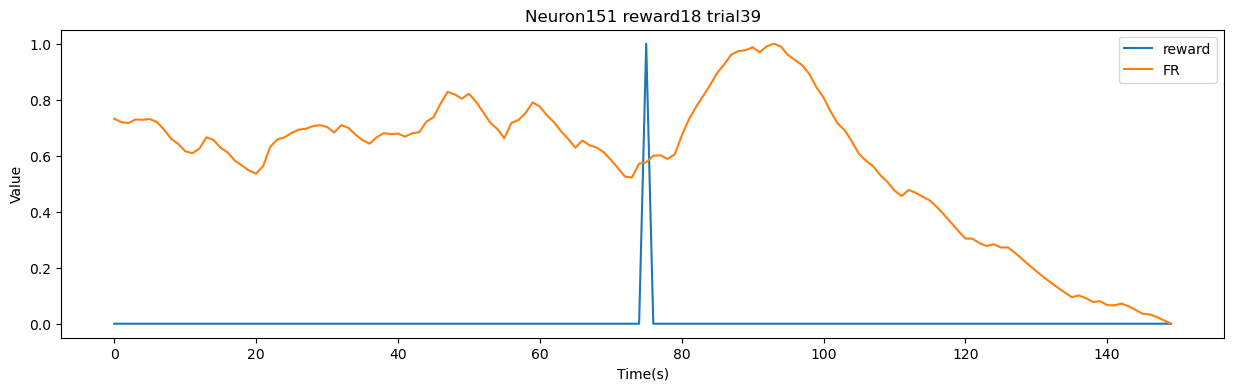

In [160]:
neuron_idx = 151
data = data_high
reward_timepoints = np.where(data['reward_onset'] > 0)[1]

time = np.arange(data['spike'].shape[1])/15
# time = np.arange(1000)/30
plt.figure(figsize=(15, 4))

plt.plot(time, normalize(data['reward_onset'].T), label='reward')
plt.plot(time, normalize(data['spike'].mean(axis=0)), label='FR')
plt.title(f'Neuron{neuron_idx}')

for trial in range(40):    
    time = np.arange(150)
    # time = np.arange(1000)/30
    plt.figure(figsize=(15, 4))
    plt.plot(time, normalize(data['reward_onset'].flatten()[reward_timepoints[trial]-75:reward_timepoints[trial]+75]), label='reward')
    plt.plot(time, normalize(data['calcium_trace'][:,reward_timepoints[trial]-75:reward_timepoints[trial]+75].mean(axis=0)), label='FR')
    plt.xlabel('Time(s)')
    plt.ylabel('Value')
    plt.title(f'Neuron{neuron_idx} reward{data['trialRewards'][trial]} trial{trial}')
    plt.legend()
    plt.show()


/var/folders/1d/3f6qhfb92hb9z89m_7hb4zlc0000gn/T/ipykernel_54957/2031005793.py:87: RuntimeWarning: invalid value encountered in divide
  return (data-data.mean(axis=axis, keepdims=True))/data.std(axis=axis, keepdims=True)


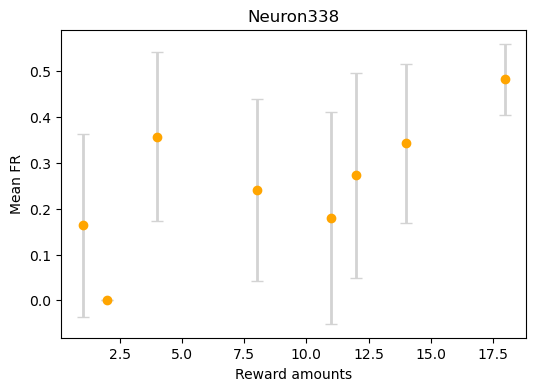

In [241]:
reward_amounts = [1,2,4,8,11,12,14,18]

neuron_idx = 338

firing_rate = data['spike'][neuron_idx,:]
singleneuron_meanFR_reward = np.zeros(40)
for i in range(40):
    # singleneuron_meanFR_reward[i] = firing_rate[ms_rewardTimes[i]:ms_rewardTimes[i]+15].mean() - firing_rate[ms_rewardTimes[i]-15:ms_rewardTimes[i]].mean() 
    singleneuron_meanFR_reward[i] = firing_rate[ms_rewardTimes[i]:ms_rewardTimes[i]+15].mean()
    zscored_singleneuron_meanFR = z_score(singleneuron_meanFR_reward, axis=0)


plt.figure(figsize=(6, 4))

for reward_amount in reward_amounts:
    # mean = np.mean(zscored_singleneuron_meanFR[trialRewards == reward_amount])
    # std = np.std(zscored_singleneuron_meanFR[trialRewards == reward_amount])
    mean = np.mean(singleneuron_meanFR_reward[trialRewards == reward_amount])
    std = np.std(singleneuron_meanFR_reward[trialRewards == reward_amount])
    #plt.scatter(reward_amount, mean, color='orange', s=50)
    plt.errorbar(reward_amount, mean, yerr=std, fmt='o', color='orange', ecolor='lightgray', elinewidth=2, capsize=4)
plt.xlabel('Reward amounts')
plt.ylabel('Mean FR')
plt.title(f'Neuron{neuron_idx}')
# plt.savefig(f'{folder_path}neuron{neuron_idx}_saperate')
plt.show()
